In [1]:
# Core
import os, re, math, random, json
from pathlib import Path

import numpy as np
import pandas as pd

# Torch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, random_split

# Utils
from IPython.display import display
import matplotlib.pyplot as plt

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE

'cuda'

In [2]:
import torch
print("Torch version:", torch.__version__)
print("Built with CUDA:", torch.version.cuda)
print("CUDA available:", torch.cuda.is_available())
print("Device count:", torch.cuda.device_count())
if torch.cuda.is_available():
    print("GPU name:", torch.cuda.get_device_name(0))


Torch version: 2.8.0+cu129
Built with CUDA: 12.9
CUDA available: True
Device count: 1
GPU name: NVIDIA GeForce RTX 3060 Laptop GPU


In [4]:
ROOT = Path.cwd()  # current working directory (your notebook dir)
DATA_RAW = "C:/Users/Akshat/Desktop/Hopkins/Fall_2025/Computational_genomics/Project/Cancer-Tumor-promoter-Generation/data/raw"
DATA_PROC = "C:/Users/Akshat/Desktop/Hopkins/Fall_2025/Computational_genomics/Project/Cancer-Tumor-promoter-Generation/data/processed"
MODELS = "C:/Users/Akshat/Desktop/Hopkins/Fall_2025/Computational_genomics/Project/Cancer-Tumor-promoter-Generation/models"
RESULTS = "/C:/Users/Akshat/Desktop/Hopkins/Fall_2025/Computational_genomics/Project/Cancer-Tumor-promoter-Generation/results"


# CHANGE THIS if your file lives elsewhere:
DATA_PATH = DATA_RAW + "/promoters.data"

DATA_PATH, DATA_RAW, DATA_PROC, MODELS, RESULTS

('C:/Users/Akshat/Desktop/Hopkins/Fall_2025/Computational_genomics/Project/Cancer-Tumor-promoter-Generation/data/raw/promoters.data',
 'C:/Users/Akshat/Desktop/Hopkins/Fall_2025/Computational_genomics/Project/Cancer-Tumor-promoter-Generation/data/raw',
 'C:/Users/Akshat/Desktop/Hopkins/Fall_2025/Computational_genomics/Project/Cancer-Tumor-promoter-Generation/data/processed',
 'C:/Users/Akshat/Desktop/Hopkins/Fall_2025/Computational_genomics/Project/Cancer-Tumor-promoter-Generation/models',
 '/C:/Users/Akshat/Desktop/Hopkins/Fall_2025/Computational_genomics/Project/Cancer-Tumor-promoter-Generation/results')

In [5]:
# Peek at the first 20 lines of the dataset
with open(DATA_PATH) as f:
    for i in range(20):
        line = f.readline()
        if not line:
            break
        print(repr(line))

'+,S10,\t\ttactagcaatacgcttgcgttcggtggttaagtatgtataatgcgcgggcttgtcgt\n'
'+,AMPC,\t\ttgctatcctgacagttgtcacgctgattggtgtcgttacaatctaacgcatcgccaa\n'
'+,AROH,\t\tgtactagagaactagtgcattagcttatttttttgttatcatgctaaccacccggcg\n'
'+,DEOP2,\taattgtgatgtgtatcgaagtgtgttgcggagtagatgttagaatactaacaaactc\n'
'+,LEU1_TRNA,\ttcgataattaactattgacgaaaagctgaaaaccactagaatgcgcctccgtggtag\n'
'+,MALEFG,\taggggcaaggaggatggaaagaggttgccgtataaagaaactagagtccgtttaggt\n'
'+,MALK,\t\tcagggggtggaggatttaagccatctcctgatgacgcatagtcagcccatcatgaat\n'
'+,RECA,\t\ttttctacaaaacacttgatactgtatgagcatacagtataattgcttcaacagaaca\n'
'+,RPOB,\t\tcgacttaatatactgcgacaggacgtccgttctgtgtaaatcgcaatgaaatggttt\n'
'+,RRNAB_P1,\tttttaaatttcctcttgtcaggccggaataactccctataatgcgccaccactgaca\n'
'+,RRNAB_P2,\tgcaaaaataaatgcttgactctgtagcgggaaggcgtattatgcacaccccgcgccg\n'
'+,RRNDEX_P2,\tcctgaaattcagggttgactctgaaagaggaaagcgtaatatacgccacctcgcgac\n'
'+,RRND_P1,\tgatcaaaaaaatacttgtgcaaaaaattgggatccctataatgcgcctccgttgaga\n'
'+,RRNE_P1,\tctgcaatttttctattgcggcctgcggag

In [6]:
def parse_uci_lines(lines):
    """
    Parses promoter data formatted as:
      +,GENENAME,sequence
      -,GENENAME,sequence
    Returns list of (label:int, sequence:str)
    """
    out = []
    for ln in lines:
        ln = ln.strip()
        if not ln or ln.startswith("#"):
            continue
        # Format like '+,GENE,sequence'
        m = re.match(r'^([+\-]),\s*([^,]+),\s*([ACGTacgt]+)', ln)
        if m:
            label = 1 if m.group(1) == '+' else 0
            gene = m.group(2).strip()
            seq = m.group(3).upper()
            out.append((label, seq))
    return out

# re-run parser
with open(DATA_PATH) as f:
    pairs = parse_uci_lines(f.readlines())
print(f"Parsed {len(pairs)} sequences from {DATA_PATH}")

# preview first 3
for i in range(3):
    print(pairs[i])

Parsed 106 sequences from C:/Users/Akshat/Desktop/Hopkins/Fall_2025/Computational_genomics/Project/Cancer-Tumor-promoter-Generation/data/raw/promoters.data
(1, 'TACTAGCAATACGCTTGCGTTCGGTGGTTAAGTATGTATAATGCGCGGGCTTGTCGT')
(1, 'TGCTATCCTGACAGTTGTCACGCTGATTGGTGTCGTTACAATCTAACGCATCGCCAA')
(1, 'GTACTAGAGAACTAGTGCATTAGCTTATTTTTTTGTTATCATGCTAACCACCCGGCG')


In [7]:
import re, numpy as np

L = 200  # fixed sequence length
base2idx = {'A':0, 'C':1, 'G':2, 'T':3}

def one_hot(seq, L=200):
    s = re.sub(r'[^ACGTacgt]', 'A', seq).upper()
    s = s[:L].ljust(L, 'A')  # pad to fixed length
    x = np.zeros((L,4), dtype=np.float32)
    for i,ch in enumerate(s):
        x[i, base2idx.get(ch, 0)] = 1.0
    return x

X = np.stack([one_hot(seq, L=L) for _, seq in pairs])
y = np.array([lab for lab,_ in pairs], dtype=np.int64)

print("Shape:", X.shape, "Promoters:", (y==1).sum(), "Non-promoters:", (y==0).sum())

Shape: (106, 200, 4) Promoters: 53 Non-promoters: 53


In [8]:
from torch.utils.data import TensorDataset, DataLoader, random_split
import torch

PROC_PATH = Path("data/processed/uci_promoters_l200.npz")
np.savez_compressed(PROC_PATH, X=X, y=y)
print("Saved", PROC_PATH)

Xt = torch.from_numpy(X)
ds = TensorDataset(Xt)
n_total = len(ds)
n_val = int(0.15 * n_total)
n_train = n_total - n_val

train_ds, val_ds = random_split(ds, [n_train, n_val], generator=torch.Generator().manual_seed(42))
train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=32, shuffle=False)

print(f"Train: {n_train}, Val: {n_val}")

Saved data\processed\uci_promoters_l200.npz
Train: 91, Val: 15


In [9]:
import torch.nn as nn
import torch.nn.functional as F

class ConvVAE(nn.Module):
    def __init__(self, L=200, z_dim=128, base_c=64, tau_start=1.0):
        super().__init__()
        self.L = L
        self.z_dim = z_dim
        self.tau = tau_start

        # Encoder
        self.enc = nn.Sequential(
            nn.Conv1d(4, base_c, 7, padding=3), nn.ReLU(),
            nn.Conv1d(base_c, base_c*2, 5, padding=2), nn.ReLU(),
            nn.AdaptiveAvgPool1d(1)
        )
        self.mu = nn.Linear(base_c*2, z_dim)
        self.logvar = nn.Linear(base_c*2, z_dim)

        # Decoder
        self.fc = nn.Linear(z_dim, base_c*2)
        self.dec = nn.Sequential(
            nn.Conv1d(base_c*2, base_c, 5, padding=2), nn.ReLU(),
            nn.Conv1d(base_c, 4, 1)
        )

    def encode(self, x):
        h = self.enc(x.transpose(1,2)).squeeze(-1)
        return self.mu(h), self.logvar(h)

    def reparam(self, mu, logvar):
        std = (0.5 * logvar).exp()
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode_logits(self, z):
        h = self.fc(z).unsqueeze(-1).repeat(1,1,self.L)
        logits = self.dec(h).transpose(1,2)
        return logits

    def forward(self, x, tau=None):
        tau = self.tau if tau is None else tau
        mu, logvar = self.encode(x)
        z = self.reparam(mu, logvar)
        logits = self.decode_logits(z)
        g = F.gumbel_softmax(logits, tau=tau, hard=False, dim=-1)
        return logits, g, mu, logvar

In [10]:
def kl_anneal(epoch, total=30, beta_max=0.1):
    return min(beta_max, beta_max * (epoch / total))

def tau_schedule(epoch, total=100, tau_start=1.0, tau_end=0.5):
    import math
    t = 0.5 * (1 + math.cos(math.pi * epoch / total))
    return tau_end + (tau_start - tau_end) * t

In [11]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
model = ConvVAE(L=L, z_dim=128, base_c=64).to(DEVICE)
opt = torch.optim.AdamW(model.parameters(), lr=3e-4)

EPOCHS = 300
best_val = float("inf")
history = {"train": [], "val": []}

for epoch in range(1, EPOCHS+1):
    model.train()
    beta = kl_anneal(epoch)
    model.tau = tau_schedule(epoch)
    tr_loss = 0

    for (xb,) in train_dl:
        xb = xb.to(DEVICE)
        logits, g, mu, logvar = model(xb)
        target = xb.argmax(-1)
        recon = F.cross_entropy(logits.reshape(-1, 4), target.reshape(-1))
        kl = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
        loss = recon + beta * kl

        opt.zero_grad()
        loss.backward()
        opt.step()
        tr_loss += loss.item() * xb.size(0)

    tr_loss /= len(train_dl.dataset)

    # Validation
    model.eval()
    va_loss = 0
    with torch.no_grad():
        for (xb,) in val_dl:
            xb = xb.to(DEVICE)
            logits, g, mu, logvar = model(xb)
            target = xb.argmax(-1)
            recon = F.cross_entropy(logits.reshape(-1, 4), target.reshape(-1))
            kl = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
            loss = recon + beta * kl
            va_loss += loss.item() * xb.size(0)
    va_loss /= len(val_dl.dataset)

    print(f"Epoch {epoch:03d}: Train={tr_loss:.4f} Val={va_loss:.4f} Beta={beta:.3f} Tau={model.tau:.3f}")
    history["train"].append(tr_loss)
    history["val"].append(va_loss)

    if va_loss < best_val:
        best_val = va_loss
        torch.save(model.state_dict(), "models/vae_uci.pt")

Epoch 001: Train=1.3523 Val=1.3289 Beta=0.003 Tau=1.000
Epoch 002: Train=1.3261 Val=1.2734 Beta=0.007 Tau=1.000
Epoch 003: Train=1.2646 Val=1.1879 Beta=0.010 Tau=0.999
Epoch 004: Train=1.1980 Val=1.1596 Beta=0.013 Tau=0.998
Epoch 005: Train=1.1306 Val=1.0899 Beta=0.017 Tau=0.997
Epoch 006: Train=1.0481 Val=0.9408 Beta=0.020 Tau=0.996
Epoch 007: Train=0.9456 Val=0.8503 Beta=0.023 Tau=0.994
Epoch 008: Train=0.8360 Val=0.7666 Beta=0.027 Tau=0.992
Epoch 009: Train=0.8096 Val=0.7930 Beta=0.030 Tau=0.990
Epoch 010: Train=0.8206 Val=0.8141 Beta=0.033 Tau=0.988
Epoch 011: Train=0.8260 Val=0.7861 Beta=0.037 Tau=0.985
Epoch 012: Train=0.7825 Val=0.7513 Beta=0.040 Tau=0.982
Epoch 013: Train=0.7785 Val=0.7522 Beta=0.043 Tau=0.979
Epoch 014: Train=0.7968 Val=0.7700 Beta=0.047 Tau=0.976
Epoch 015: Train=0.7826 Val=0.7679 Beta=0.050 Tau=0.973
Epoch 016: Train=0.7849 Val=0.7555 Beta=0.053 Tau=0.969
Epoch 017: Train=0.7753 Val=0.7414 Beta=0.057 Tau=0.965
Epoch 018: Train=0.7726 Val=0.7436 Beta=0.060 Ta

In [13]:
import torch
import torch.nn.functional as F
from tqdm import tqdm

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# ----------------------------- Hyperparameters -----------------------------
EPOCHS_PRETRAIN = 30      # phase 1: reconstruction only
EPOCHS_VAE = 150          # phase 2: full VAE training
LR = 0.01                 # learning rate
BETA_MAX = 0.2            # smaller KL weight = better recon
TAU_START, TAU_END = 1.0, 0.5
CLIP_NORM = 1.0
BATCH_SIZE = 32
MODEL_PATH = Path("models/vae_uci_tuned.pt")

# ----------------------------- Utility Functions -----------------------------
def kl_anneal(epoch, total=30, beta_max=0.2):
    """Linearly ramp up the KL term"""
    return min(beta_max, beta_max * (epoch / max(1, total)))

def tau_schedule(epoch, total=100, tau_start=1.0, tau_end=0.5):
    """Cosine temperature decay for Gumbel-softmax"""
    import math
    t = 0.5 * (1 + math.cos(math.pi * epoch / total))
    return tau_end + (tau_start - tau_end) * t

# ----------------------------- Setup -----------------------------
model = ConvVAE(L=L, z_dim=128, base_c=64).to(DEVICE)
opt = torch.optim.AdamW(model.parameters(), lr=LR)

# DataLoaders
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)

history = {"train": [], "val": []}
best_val = float("inf")

# ----------------------------- Phase 1: Autoencoder pretraining -----------------------------
print("\n===== Phase 1: Autoencoder pretraining (no KL term) =====")

for epoch in range(1, EPOCHS_PRETRAIN + 1):
    model.train()
    tr_loss = 0.0
    for (xb,) in tqdm(train_dl, desc=f"Pretrain {epoch}/{EPOCHS_PRETRAIN}"):
        xb = xb.to(DEVICE)
        logits, g, mu, logvar = model(xb)
        target = xb.argmax(-1)
        recon = F.cross_entropy(logits.reshape(-1, 4), target.reshape(-1))

        opt.zero_grad(set_to_none=True)
        recon.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), CLIP_NORM)
        opt.step()

        tr_loss += recon.item() * xb.size(0)
    tr_loss /= len(train_dl.dataset)

    # validation
    model.eval()
    va_loss = 0
    with torch.no_grad():
        for (xb,) in val_dl:
            xb = xb.to(DEVICE)
            logits, g, mu, logvar = model(xb)
            target = xb.argmax(-1)
            recon = F.cross_entropy(logits.reshape(-1, 4), target.reshape(-1))
            va_loss += recon.item() * xb.size(0)
    va_loss /= len(val_dl.dataset)

    print(f"Epoch {epoch:03d}: TrainRecon={tr_loss:.4f}  ValRecon={va_loss:.4f}")

# ----------------------------- Phase 2: Full VAE training -----------------------------
print("\n===== Phase 2: Variational fine-tuning =====")

for epoch in range(1, EPOCHS_VAE + 1):
    model.train()
    beta = kl_anneal(epoch, total=50, beta_max=BETA_MAX)
    model.tau = tau_schedule(epoch, total=EPOCHS_VAE, tau_start=TAU_START, tau_end=TAU_END)

    tr_loss = 0.0
    for (xb,) in tqdm(train_dl, desc=f"VAE {epoch}/{EPOCHS_VAE}"):
        xb = xb.to(DEVICE)
        logits, g, mu, logvar = model(xb)
        target = xb.argmax(-1)
        recon = F.cross_entropy(logits.reshape(-1, 4), target.reshape(-1))
        kl = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
        loss = recon + beta * kl

        opt.zero_grad(set_to_none=True)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), CLIP_NORM)
        opt.step()
        tr_loss += loss.item() * xb.size(0)
    tr_loss /= len(train_dl.dataset)

    # Validation
    model.eval()
    va_loss = 0.0
    with torch.no_grad():
        for (xb,) in val_dl:
            xb = xb.to(DEVICE)
            logits, g, mu, logvar = model(xb)
            target = xb.argmax(-1)
            recon = F.cross_entropy(logits.reshape(-1, 4), target.reshape(-1))
            kl = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
            loss = recon + beta * kl
            va_loss += loss.item() * xb.size(0)
    va_loss /= len(val_dl.dataset)

    history["train"].append(tr_loss)
    history["val"].append(va_loss)

    print(f"Epoch {epoch:03d}: Train={tr_loss:.4f}  Val={va_loss:.4f}  β={beta:.3f}  τ={model.tau:.3f}")

    if va_loss < best_val:
        best_val = va_loss
        torch.save(model.state_dict(), MODEL_PATH)
        print(f"✅ Saved best model to {MODEL_PATH} (val={best_val:.4f})")


===== Phase 1: Autoencoder pretraining (no KL term) =====


Pretrain 1/30: 100%|██████████| 3/3 [00:00<00:00, 46.48it/s]


Epoch 001: TrainRecon=2.0489  ValRecon=2.0973


Pretrain 2/30: 100%|██████████| 3/3 [00:00<00:00, 41.16it/s]


Epoch 002: TrainRecon=1.3841  ValRecon=0.7799


Pretrain 3/30: 100%|██████████| 3/3 [00:00<00:00, 73.84it/s]


Epoch 003: TrainRecon=0.8418  ValRecon=0.7894


Pretrain 4/30: 100%|██████████| 3/3 [00:00<00:00, 233.94it/s]


Epoch 004: TrainRecon=0.8416  ValRecon=0.7902


Pretrain 5/30: 100%|██████████| 3/3 [00:00<00:00, 170.42it/s]


Epoch 005: TrainRecon=0.8051  ValRecon=0.7659


Pretrain 6/30: 100%|██████████| 3/3 [00:00<00:00, 147.74it/s]


Epoch 006: TrainRecon=0.7858  ValRecon=0.7490


Pretrain 7/30: 100%|██████████| 3/3 [00:00<00:00, 156.40it/s]


Epoch 007: TrainRecon=0.7722  ValRecon=0.7479


Pretrain 8/30: 100%|██████████| 3/3 [00:00<00:00, 169.12it/s]


Epoch 008: TrainRecon=0.7701  ValRecon=0.7404


Pretrain 9/30: 100%|██████████| 3/3 [00:00<00:00, 211.79it/s]


Epoch 009: TrainRecon=0.7596  ValRecon=0.7433


Pretrain 10/30: 100%|██████████| 3/3 [00:00<00:00, 212.92it/s]


Epoch 010: TrainRecon=0.7625  ValRecon=0.7427


Pretrain 11/30: 100%|██████████| 3/3 [00:00<00:00, 216.22it/s]


Epoch 011: TrainRecon=0.7600  ValRecon=0.7448


Pretrain 12/30: 100%|██████████| 3/3 [00:00<00:00, 236.28it/s]


Epoch 012: TrainRecon=0.7597  ValRecon=0.7373


Pretrain 13/30: 100%|██████████| 3/3 [00:00<00:00, 233.98it/s]


Epoch 013: TrainRecon=0.7619  ValRecon=0.7551


Pretrain 14/30: 100%|██████████| 3/3 [00:00<00:00, 170.32it/s]


Epoch 014: TrainRecon=0.7594  ValRecon=0.7325


Pretrain 15/30: 100%|██████████| 3/3 [00:00<00:00, 188.49it/s]

Epoch 015: TrainRecon=0.7529  ValRecon=0.7345



Pretrain 16/30: 100%|██████████| 3/3 [00:00<00:00, 191.35it/s]


Epoch 016: TrainRecon=0.7506  ValRecon=0.7253


Pretrain 17/30: 100%|██████████| 3/3 [00:00<00:00, 189.01it/s]


Epoch 017: TrainRecon=0.7493  ValRecon=0.7233


Pretrain 18/30: 100%|██████████| 3/3 [00:00<00:00, 142.22it/s]


Epoch 018: TrainRecon=0.7463  ValRecon=0.7179


Pretrain 19/30: 100%|██████████| 3/3 [00:00<00:00, 190.33it/s]


Epoch 019: TrainRecon=0.7453  ValRecon=0.7187


Pretrain 20/30: 100%|██████████| 3/3 [00:00<00:00, 242.61it/s]


Epoch 020: TrainRecon=0.7441  ValRecon=0.7209


Pretrain 21/30: 100%|██████████| 3/3 [00:00<00:00, 227.82it/s]


Epoch 021: TrainRecon=0.7441  ValRecon=0.7176


Pretrain 22/30: 100%|██████████| 3/3 [00:00<00:00, 177.09it/s]


Epoch 022: TrainRecon=0.7434  ValRecon=0.7182


Pretrain 23/30: 100%|██████████| 3/3 [00:00<00:00, 182.09it/s]


Epoch 023: TrainRecon=0.7430  ValRecon=0.7171


Pretrain 24/30: 100%|██████████| 3/3 [00:00<00:00, 197.84it/s]


Epoch 024: TrainRecon=0.7424  ValRecon=0.7179


Pretrain 25/30: 100%|██████████| 3/3 [00:00<00:00, 208.31it/s]


Epoch 025: TrainRecon=0.7423  ValRecon=0.7173


Pretrain 26/30: 100%|██████████| 3/3 [00:00<00:00, 207.13it/s]


Epoch 026: TrainRecon=0.7420  ValRecon=0.7168


Pretrain 27/30: 100%|██████████| 3/3 [00:00<00:00, 179.58it/s]


Epoch 027: TrainRecon=0.7417  ValRecon=0.7169


Pretrain 28/30: 100%|██████████| 3/3 [00:00<00:00, 175.42it/s]


Epoch 028: TrainRecon=0.7420  ValRecon=0.7179


Pretrain 29/30: 100%|██████████| 3/3 [00:00<00:00, 239.42it/s]


Epoch 029: TrainRecon=0.7413  ValRecon=0.7171


Pretrain 30/30: 100%|██████████| 3/3 [00:00<00:00, 178.31it/s]


Epoch 030: TrainRecon=0.7415  ValRecon=0.7162

===== Phase 2: Variational fine-tuning =====


VAE 1/150: 100%|██████████| 3/3 [00:00<00:00, 166.11it/s]


Epoch 001: Train=0.7492  Val=0.7246  β=0.004  τ=1.000
✅ Saved best model to models\vae_uci_tuned.pt (val=0.7246)


VAE 2/150: 100%|██████████| 3/3 [00:00<00:00, 189.69it/s]


Epoch 002: Train=0.7563  Val=0.7302  β=0.008  τ=1.000


VAE 3/150: 100%|██████████| 3/3 [00:00<00:00, 173.93it/s]


Epoch 003: Train=0.7603  Val=0.7316  β=0.012  τ=1.000


VAE 4/150: 100%|██████████| 3/3 [00:00<00:00, 160.28it/s]


Epoch 004: Train=0.7603  Val=0.7309  β=0.016  τ=0.999


VAE 5/150: 100%|██████████| 3/3 [00:00<00:00, 154.87it/s]


Epoch 005: Train=0.7562  Val=0.7297  β=0.020  τ=0.999


VAE 6/150: 100%|██████████| 3/3 [00:00<00:00, 157.39it/s]


Epoch 006: Train=0.7530  Val=0.7250  β=0.024  τ=0.998


VAE 7/150: 100%|██████████| 3/3 [00:00<00:00, 148.46it/s]


Epoch 007: Train=0.7532  Val=0.7313  β=0.028  τ=0.997


VAE 8/150: 100%|██████████| 3/3 [00:00<00:00, 154.52it/s]


Epoch 008: Train=0.7554  Val=0.7338  β=0.032  τ=0.996


VAE 9/150: 100%|██████████| 3/3 [00:00<00:00, 170.78it/s]


Epoch 009: Train=0.7565  Val=0.7310  β=0.036  τ=0.996


VAE 10/150: 100%|██████████| 3/3 [00:00<00:00, 207.99it/s]

Epoch 010: Train=0.7623  Val=0.7292  β=0.040  τ=0.995

VAE 11/150: 100%|██████████| 3/3 [00:00<00:00, 175.58it/s]


Epoch 011: Train=0.7609  Val=0.7375  β=0.044  τ=0.993


VAE 12/150: 100%|██████████| 3/3 [00:00<00:00, 187.10it/s]


Epoch 012: Train=0.7667  Val=0.7398  β=0.048  τ=0.992


VAE 13/150: 100%|██████████| 3/3 [00:00<00:00, 171.39it/s]


Epoch 013: Train=0.7615  Val=0.7333  β=0.052  τ=0.991


VAE 14/150: 100%|██████████| 3/3 [00:00<00:00, 210.08it/s]


Epoch 014: Train=0.7598  Val=0.7332  β=0.056  τ=0.989


VAE 15/150: 100%|██████████| 3/3 [00:00<00:00, 191.93it/s]


Epoch 015: Train=0.7604  Val=0.7545  β=0.060  τ=0.988


VAE 16/150: 100%|██████████| 3/3 [00:00<00:00, 164.19it/s]


Epoch 016: Train=0.7625  Val=0.7393  β=0.064  τ=0.986


VAE 17/150: 100%|██████████| 3/3 [00:00<00:00, 174.05it/s]


Epoch 017: Train=0.7624  Val=0.7336  β=0.068  τ=0.984


VAE 18/150: 100%|██████████| 3/3 [00:00<00:00, 214.59it/s]


Epoch 018: Train=0.7612  Val=0.7343  β=0.072  τ=0.982


VAE 19/150: 100%|██████████| 3/3 [00:00<00:00, 152.94it/s]


Epoch 019: Train=0.7600  Val=0.7332  β=0.076  τ=0.980


VAE 20/150: 100%|██████████| 3/3 [00:00<00:00, 194.23it/s]


Epoch 020: Train=0.7615  Val=0.7323  β=0.080  τ=0.978


VAE 21/150: 100%|██████████| 3/3 [00:00<00:00, 183.19it/s]


Epoch 021: Train=0.7592  Val=0.7325  β=0.084  τ=0.976


VAE 22/150: 100%|██████████| 3/3 [00:00<00:00, 146.40it/s]


Epoch 022: Train=0.7600  Val=0.7348  β=0.088  τ=0.974


VAE 23/150: 100%|██████████| 3/3 [00:00<00:00, 159.19it/s]


Epoch 023: Train=0.7636  Val=0.7374  β=0.092  τ=0.972


VAE 24/150: 100%|██████████| 3/3 [00:00<00:00, 178.39it/s]


Epoch 024: Train=0.7645  Val=0.7316  β=0.096  τ=0.969


VAE 25/150: 100%|██████████| 3/3 [00:00<00:00, 184.89it/s]


Epoch 025: Train=0.7609  Val=0.7330  β=0.100  τ=0.967


VAE 26/150: 100%|██████████| 3/3 [00:00<00:00, 131.27it/s]


Epoch 026: Train=0.7627  Val=0.7380  β=0.104  τ=0.964


VAE 27/150: 100%|██████████| 3/3 [00:00<00:00, 146.88it/s]


Epoch 027: Train=0.7613  Val=0.7415  β=0.108  τ=0.961


VAE 28/150: 100%|██████████| 3/3 [00:00<00:00, 164.99it/s]


Epoch 028: Train=0.7631  Val=0.7430  β=0.112  τ=0.958


VAE 29/150: 100%|██████████| 3/3 [00:00<00:00, 159.03it/s]


Epoch 029: Train=0.7649  Val=0.7463  β=0.116  τ=0.955


VAE 30/150: 100%|██████████| 3/3 [00:00<00:00, 159.38it/s]


Epoch 030: Train=0.7681  Val=0.7357  β=0.120  τ=0.952


VAE 31/150: 100%|██████████| 3/3 [00:00<00:00, 174.10it/s]


Epoch 031: Train=0.7627  Val=0.7327  β=0.124  τ=0.949


VAE 32/150: 100%|██████████| 3/3 [00:00<00:00, 158.57it/s]


Epoch 032: Train=0.7597  Val=0.7320  β=0.128  τ=0.946


VAE 33/150: 100%|██████████| 3/3 [00:00<00:00, 175.05it/s]


Epoch 033: Train=0.7632  Val=0.7371  β=0.132  τ=0.943


VAE 34/150: 100%|██████████| 3/3 [00:00<00:00, 184.97it/s]


Epoch 034: Train=0.7642  Val=0.7358  β=0.136  τ=0.939


VAE 35/150: 100%|██████████| 3/3 [00:00<00:00, 186.41it/s]


Epoch 035: Train=0.7616  Val=0.7294  β=0.140  τ=0.936


VAE 36/150: 100%|██████████| 3/3 [00:00<00:00, 159.15it/s]


Epoch 036: Train=0.7628  Val=0.7356  β=0.144  τ=0.932


VAE 37/150: 100%|██████████| 3/3 [00:00<00:00, 220.82it/s]


Epoch 037: Train=0.7629  Val=0.7334  β=0.148  τ=0.929


VAE 38/150: 100%|██████████| 3/3 [00:00<00:00, 120.27it/s]


Epoch 038: Train=0.7601  Val=0.7385  β=0.152  τ=0.925


VAE 39/150: 100%|██████████| 3/3 [00:00<00:00, 124.85it/s]


Epoch 039: Train=0.7635  Val=0.7349  β=0.156  τ=0.921


VAE 40/150: 100%|██████████| 3/3 [00:00<00:00, 161.81it/s]


Epoch 040: Train=0.7575  Val=0.7324  β=0.160  τ=0.917


VAE 41/150: 100%|██████████| 3/3 [00:00<00:00, 152.42it/s]


Epoch 041: Train=0.7600  Val=0.7377  β=0.164  τ=0.913


VAE 42/150: 100%|██████████| 3/3 [00:00<00:00, 173.24it/s]


Epoch 042: Train=0.7590  Val=0.7432  β=0.168  τ=0.909


VAE 43/150: 100%|██████████| 3/3 [00:00<00:00, 165.50it/s]


Epoch 043: Train=0.7608  Val=0.7343  β=0.172  τ=0.905


VAE 44/150: 100%|██████████| 3/3 [00:00<00:00, 173.40it/s]


Epoch 044: Train=0.7586  Val=0.7359  β=0.176  τ=0.901


VAE 45/150: 100%|██████████| 3/3 [00:00<00:00, 177.55it/s]


Epoch 045: Train=0.7602  Val=0.7426  β=0.180  τ=0.897


VAE 46/150: 100%|██████████| 3/3 [00:00<00:00, 146.03it/s]


Epoch 046: Train=0.7586  Val=0.7316  β=0.184  τ=0.893


VAE 47/150: 100%|██████████| 3/3 [00:00<00:00, 204.45it/s]


Epoch 047: Train=0.7591  Val=0.7350  β=0.188  τ=0.888


VAE 48/150: 100%|██████████| 3/3 [00:00<00:00, 160.65it/s]


Epoch 048: Train=0.7607  Val=0.7326  β=0.192  τ=0.884


VAE 49/150: 100%|██████████| 3/3 [00:00<00:00, 183.39it/s]


Epoch 049: Train=0.7601  Val=0.7337  β=0.196  τ=0.880


VAE 50/150: 100%|██████████| 3/3 [00:00<00:00, 166.96it/s]

Epoch 050: Train=0.7605  Val=0.7336  β=0.200  τ=0.875

VAE 51/150: 100%|██████████| 3/3 [00:00<00:00, 156.73it/s]


Epoch 051: Train=0.7583  Val=0.7389  β=0.200  τ=0.870


VAE 52/150: 100%|██████████| 3/3 [00:00<00:00, 167.91it/s]


Epoch 052: Train=0.7580  Val=0.7336  β=0.200  τ=0.866


VAE 53/150: 100%|██████████| 3/3 [00:00<00:00, 162.14it/s]


Epoch 053: Train=0.7569  Val=0.7285  β=0.200  τ=0.861


VAE 54/150: 100%|██████████| 3/3 [00:00<00:00, 154.58it/s]


Epoch 054: Train=0.7589  Val=0.7304  β=0.200  τ=0.856


VAE 55/150: 100%|██████████| 3/3 [00:00<00:00, 187.53it/s]


Epoch 055: Train=0.7541  Val=0.7290  β=0.200  τ=0.852


VAE 56/150: 100%|██████████| 3/3 [00:00<00:00, 161.89it/s]


Epoch 056: Train=0.7569  Val=0.7283  β=0.200  τ=0.847


VAE 57/150: 100%|██████████| 3/3 [00:00<00:00, 208.80it/s]


Epoch 057: Train=0.7561  Val=0.7272  β=0.200  τ=0.842


VAE 58/150: 100%|██████████| 3/3 [00:00<00:00, 155.66it/s]


Epoch 058: Train=0.7570  Val=0.7344  β=0.200  τ=0.837


VAE 59/150: 100%|██████████| 3/3 [00:00<00:00, 155.94it/s]


Epoch 059: Train=0.7561  Val=0.7295  β=0.200  τ=0.832


VAE 60/150: 100%|██████████| 3/3 [00:00<00:00, 170.05it/s]


Epoch 060: Train=0.7561  Val=0.7332  β=0.200  τ=0.827


VAE 61/150: 100%|██████████| 3/3 [00:00<00:00, 180.20it/s]


Epoch 061: Train=0.7649  Val=0.7360  β=0.200  τ=0.822


VAE 62/150: 100%|██████████| 3/3 [00:00<00:00, 162.77it/s]


Epoch 062: Train=0.7610  Val=0.7428  β=0.200  τ=0.817


VAE 63/150: 100%|██████████| 3/3 [00:00<00:00, 166.55it/s]


Epoch 063: Train=0.7628  Val=0.7449  β=0.200  τ=0.812


VAE 64/150: 100%|██████████| 3/3 [00:00<00:00, 195.26it/s]


Epoch 064: Train=0.7608  Val=0.7314  β=0.200  τ=0.807


VAE 65/150: 100%|██████████| 3/3 [00:00<00:00, 173.06it/s]

Epoch 065: Train=0.7630  Val=0.7357  β=0.200  τ=0.802

VAE 66/150: 100%|██████████| 3/3 [00:00<00:00, 178.52it/s]


Epoch 066: Train=0.7589  Val=0.7804  β=0.200  τ=0.797


VAE 67/150: 100%|██████████| 3/3 [00:00<00:00, 183.78it/s]


Epoch 067: Train=0.7574  Val=0.7299  β=0.200  τ=0.792


VAE 68/150: 100%|██████████| 3/3 [00:00<00:00, 168.42it/s]


Epoch 068: Train=0.7566  Val=0.7285  β=0.200  τ=0.787


VAE 69/150: 100%|██████████| 3/3 [00:00<00:00, 198.20it/s]


Epoch 069: Train=0.7651  Val=0.7386  β=0.200  τ=0.781


VAE 70/150: 100%|██████████| 3/3 [00:00<00:00, 168.73it/s]


Epoch 070: Train=0.7607  Val=0.7396  β=0.200  τ=0.776


VAE 71/150: 100%|██████████| 3/3 [00:00<00:00, 214.73it/s]


Epoch 071: Train=0.7676  Val=0.7452  β=0.200  τ=0.771


VAE 72/150: 100%|██████████| 3/3 [00:00<00:00, 162.08it/s]


Epoch 072: Train=0.7741  Val=0.7402  β=0.200  τ=0.766


VAE 73/150: 100%|██████████| 3/3 [00:00<00:00, 157.99it/s]


Epoch 073: Train=0.7635  Val=0.7279  β=0.200  τ=0.760


VAE 74/150: 100%|██████████| 3/3 [00:00<00:00, 159.45it/s]


Epoch 074: Train=0.7808  Val=0.7336  β=0.200  τ=0.755


VAE 75/150: 100%|██████████| 3/3 [00:00<00:00, 136.64it/s]


Epoch 075: Train=0.7713  Val=0.7454  β=0.200  τ=0.750


VAE 76/150: 100%|██████████| 3/3 [00:00<00:00, 185.91it/s]


Epoch 076: Train=0.7714  Val=0.7497  β=0.200  τ=0.745


VAE 77/150: 100%|██████████| 3/3 [00:00<00:00, 143.93it/s]


Epoch 077: Train=0.7738  Val=0.7425  β=0.200  τ=0.740


VAE 78/150: 100%|██████████| 3/3 [00:00<00:00, 159.48it/s]


Epoch 078: Train=0.7680  Val=0.7490  β=0.200  τ=0.734


VAE 79/150: 100%|██████████| 3/3 [00:00<00:00, 146.97it/s]


Epoch 079: Train=0.7819  Val=0.7373  β=0.200  τ=0.729


VAE 80/150: 100%|██████████| 3/3 [00:00<00:00, 136.16it/s]

Epoch 080: Train=0.7624  Val=0.7394  β=0.200  τ=0.724

VAE 81/150: 100%|██████████| 3/3 [00:00<00:00, 142.85it/s]


Epoch 081: Train=0.7635  Val=0.7388  β=0.200  τ=0.719


VAE 82/150: 100%|██████████| 3/3 [00:00<00:00, 141.99it/s]


Epoch 082: Train=0.7631  Val=0.7357  β=0.200  τ=0.713


VAE 83/150: 100%|██████████| 3/3 [00:00<00:00, 146.81it/s]


Epoch 083: Train=0.7598  Val=0.7401  β=0.200  τ=0.708


VAE 84/150: 100%|██████████| 3/3 [00:00<00:00, 123.53it/s]


Epoch 084: Train=0.7572  Val=0.7351  β=0.200  τ=0.703


VAE 85/150: 100%|██████████| 3/3 [00:00<00:00, 115.50it/s]


Epoch 085: Train=0.7599  Val=0.7355  β=0.200  τ=0.698


VAE 86/150: 100%|██████████| 3/3 [00:00<00:00, 132.76it/s]


Epoch 086: Train=0.7606  Val=0.7310  β=0.200  τ=0.693


VAE 87/150: 100%|██████████| 3/3 [00:00<00:00, 170.56it/s]


Epoch 087: Train=0.7576  Val=0.7307  β=0.200  τ=0.688


VAE 88/150: 100%|██████████| 3/3 [00:00<00:00, 156.70it/s]


Epoch 088: Train=0.7606  Val=0.7324  β=0.200  τ=0.683


VAE 89/150: 100%|██████████| 3/3 [00:00<00:00, 160.52it/s]


Epoch 089: Train=0.7672  Val=0.7328  β=0.200  τ=0.678


VAE 90/150: 100%|██████████| 3/3 [00:00<00:00, 144.19it/s]


Epoch 090: Train=0.7569  Val=0.7313  β=0.200  τ=0.673


VAE 91/150: 100%|██████████| 3/3 [00:00<00:00, 135.47it/s]


Epoch 091: Train=0.7587  Val=0.7356  β=0.200  τ=0.668


VAE 92/150: 100%|██████████| 3/3 [00:00<00:00, 151.19it/s]


Epoch 092: Train=0.7583  Val=0.7352  β=0.200  τ=0.663


VAE 93/150: 100%|██████████| 3/3 [00:00<00:00, 126.31it/s]


Epoch 093: Train=0.7573  Val=0.7348  β=0.200  τ=0.658


VAE 94/150: 100%|██████████| 3/3 [00:00<00:00, 147.79it/s]


Epoch 094: Train=0.7550  Val=0.7344  β=0.200  τ=0.653


VAE 95/150: 100%|██████████| 3/3 [00:00<00:00, 126.45it/s]


Epoch 095: Train=0.7562  Val=0.7335  β=0.200  τ=0.648


VAE 96/150: 100%|██████████| 3/3 [00:00<00:00, 103.29it/s]


Epoch 096: Train=0.7572  Val=0.7288  β=0.200  τ=0.644


VAE 97/150: 100%|██████████| 3/3 [00:00<00:00, 141.44it/s]


Epoch 097: Train=0.7562  Val=0.7318  β=0.200  τ=0.639


VAE 98/150: 100%|██████████| 3/3 [00:00<00:00, 140.70it/s]

Epoch 098: Train=0.7542  Val=0.7340  β=0.200  τ=0.634

VAE 99/150: 100%|██████████| 3/3 [00:00<00:00, 169.38it/s]


Epoch 099: Train=0.7561  Val=0.7305  β=0.200  τ=0.630


VAE 100/150: 100%|██████████| 3/3 [00:00<00:00, 140.12it/s]


Epoch 100: Train=0.7564  Val=0.7319  β=0.200  τ=0.625


VAE 101/150: 100%|██████████| 3/3 [00:00<00:00, 143.71it/s]


Epoch 101: Train=0.7577  Val=0.7356  β=0.200  τ=0.620


VAE 102/150: 100%|██████████| 3/3 [00:00<00:00, 166.68it/s]


Epoch 102: Train=0.7558  Val=0.7348  β=0.200  τ=0.616


VAE 103/150: 100%|██████████| 3/3 [00:00<00:00, 156.57it/s]


Epoch 103: Train=0.7552  Val=0.7316  β=0.200  τ=0.612


VAE 104/150: 100%|██████████| 3/3 [00:00<00:00, 156.41it/s]

Epoch 104: Train=0.7522  Val=0.7284  β=0.200  τ=0.607

VAE 105/150: 100%|██████████| 3/3 [00:00<00:00, 170.06it/s]


Epoch 105: Train=0.7517  Val=0.7290  β=0.200  τ=0.603


VAE 106/150: 100%|██████████| 3/3 [00:00<00:00, 173.25it/s]


Epoch 106: Train=0.7619  Val=0.7318  β=0.200  τ=0.599


VAE 107/150: 100%|██████████| 3/3 [00:00<00:00, 169.92it/s]


Epoch 107: Train=0.7527  Val=0.7292  β=0.200  τ=0.595


VAE 108/150: 100%|██████████| 3/3 [00:00<00:00, 153.74it/s]


Epoch 108: Train=0.7544  Val=0.7290  β=0.200  τ=0.591


VAE 109/150: 100%|██████████| 3/3 [00:00<00:00, 148.21it/s]


Epoch 109: Train=0.7535  Val=0.7300  β=0.200  τ=0.587


VAE 110/150: 100%|██████████| 3/3 [00:00<00:00, 143.82it/s]


Epoch 110: Train=0.7534  Val=0.7305  β=0.200  τ=0.583


VAE 111/150: 100%|██████████| 3/3 [00:00<00:00, 194.37it/s]


Epoch 111: Train=0.7541  Val=0.7262  β=0.200  τ=0.579


VAE 112/150: 100%|██████████| 3/3 [00:00<00:00, 163.72it/s]


Epoch 112: Train=0.7997  Val=0.7337  β=0.200  τ=0.575


VAE 113/150: 100%|██████████| 3/3 [00:00<00:00, 167.78it/s]


Epoch 113: Train=0.7594  Val=0.7366  β=0.200  τ=0.571


VAE 114/150: 100%|██████████| 3/3 [00:00<00:00, 164.61it/s]


Epoch 114: Train=0.7645  Val=0.7413  β=0.200  τ=0.568


VAE 115/150: 100%|██████████| 3/3 [00:00<00:00, 154.44it/s]


Epoch 115: Train=0.7666  Val=0.7397  β=0.200  τ=0.564


VAE 116/150: 100%|██████████| 3/3 [00:00<00:00, 145.98it/s]


Epoch 116: Train=0.7633  Val=1.0197  β=0.200  τ=0.561


VAE 117/150: 100%|██████████| 3/3 [00:00<00:00, 172.74it/s]


Epoch 117: Train=0.7632  Val=0.7497  β=0.200  τ=0.557


VAE 118/150: 100%|██████████| 3/3 [00:00<00:00, 151.86it/s]


Epoch 118: Train=0.7801  Val=0.7433  β=0.200  τ=0.554


VAE 119/150: 100%|██████████| 3/3 [00:00<00:00, 144.93it/s]


Epoch 119: Train=0.7691  Val=0.7442  β=0.200  τ=0.551


VAE 120/150: 100%|██████████| 3/3 [00:00<00:00, 126.02it/s]


Epoch 120: Train=0.7635  Val=0.7357  β=0.200  τ=0.548


VAE 121/150: 100%|██████████| 3/3 [00:00<00:00, 150.11it/s]

Epoch 121: Train=0.7653  Val=0.7381  β=0.200  τ=0.545

VAE 122/150: 100%|██████████| 3/3 [00:00<00:00, 137.79it/s]


Epoch 122: Train=0.7625  Val=0.7358  β=0.200  τ=0.542


VAE 123/150: 100%|██████████| 3/3 [00:00<00:00, 171.99it/s]

Epoch 123: Train=0.7612  Val=0.7398  β=0.200  τ=0.539

VAE 124/150: 100%|██████████| 3/3 [00:00<00:00, 168.21it/s]


Epoch 124: Train=0.7625  Val=0.7357  β=0.200  τ=0.536


VAE 125/150: 100%|██████████| 3/3 [00:00<00:00, 183.30it/s]


Epoch 125: Train=0.7609  Val=0.7375  β=0.200  τ=0.533


VAE 126/150: 100%|██████████| 3/3 [00:00<00:00, 152.18it/s]


Epoch 126: Train=0.7593  Val=0.7353  β=0.200  τ=0.531


VAE 127/150: 100%|██████████| 3/3 [00:00<00:00, 157.96it/s]


Epoch 127: Train=0.7582  Val=0.7327  β=0.200  τ=0.528


VAE 128/150: 100%|██████████| 3/3 [00:00<00:00, 132.45it/s]


Epoch 128: Train=0.7566  Val=0.7335  β=0.200  τ=0.526


VAE 129/150: 100%|██████████| 3/3 [00:00<00:00, 175.09it/s]


Epoch 129: Train=0.7561  Val=0.7338  β=0.200  τ=0.524


VAE 130/150: 100%|██████████| 3/3 [00:00<00:00, 158.23it/s]


Epoch 130: Train=0.7546  Val=0.7322  β=0.200  τ=0.522


VAE 131/150: 100%|██████████| 3/3 [00:00<00:00, 158.59it/s]


Epoch 131: Train=0.7549  Val=0.7307  β=0.200  τ=0.520


VAE 132/150: 100%|██████████| 3/3 [00:00<00:00, 180.22it/s]


Epoch 132: Train=0.7554  Val=0.7305  β=0.200  τ=0.518


VAE 133/150: 100%|██████████| 3/3 [00:00<00:00, 203.78it/s]


Epoch 133: Train=0.7533  Val=0.7291  β=0.200  τ=0.516


VAE 134/150: 100%|██████████| 3/3 [00:00<00:00, 197.53it/s]


Epoch 134: Train=0.7534  Val=0.7282  β=0.200  τ=0.514


VAE 135/150: 100%|██████████| 3/3 [00:00<00:00, 204.33it/s]


Epoch 135: Train=0.7533  Val=0.7287  β=0.200  τ=0.512


VAE 136/150: 100%|██████████| 3/3 [00:00<00:00, 167.62it/s]


Epoch 136: Train=0.7526  Val=0.7268  β=0.200  τ=0.511


VAE 137/150: 100%|██████████| 3/3 [00:00<00:00, 158.12it/s]


Epoch 137: Train=0.7519  Val=0.7273  β=0.200  τ=0.509


VAE 138/150: 100%|██████████| 3/3 [00:00<00:00, 135.43it/s]


Epoch 138: Train=0.7503  Val=0.7244  β=0.200  τ=0.508
✅ Saved best model to models\vae_uci_tuned.pt (val=0.7244)


VAE 139/150: 100%|██████████| 3/3 [00:00<00:00, 124.59it/s]


Epoch 139: Train=0.7518  Val=0.7257  β=0.200  τ=0.507


VAE 140/150: 100%|██████████| 3/3 [00:00<00:00, 127.18it/s]


Epoch 140: Train=0.9857  Val=0.7270  β=0.200  τ=0.505


VAE 141/150: 100%|██████████| 3/3 [00:00<00:00, 156.98it/s]


Epoch 141: Train=0.7528  Val=0.7293  β=0.200  τ=0.504


VAE 142/150: 100%|██████████| 3/3 [00:00<00:00, 206.00it/s]


Epoch 142: Train=0.7560  Val=0.7379  β=0.200  τ=0.504


VAE 143/150: 100%|██████████| 3/3 [00:00<00:00, 191.95it/s]


Epoch 143: Train=0.7631  Val=0.7518  β=0.200  τ=0.503


VAE 144/150: 100%|██████████| 3/3 [00:00<00:00, 182.48it/s]


Epoch 144: Train=0.7688  Val=0.7417  β=0.200  τ=0.502


VAE 145/150: 100%|██████████| 3/3 [00:00<00:00, 188.91it/s]


Epoch 145: Train=0.7612  Val=0.7384  β=0.200  τ=0.501


VAE 146/150: 100%|██████████| 3/3 [00:00<00:00, 187.78it/s]


Epoch 146: Train=0.7578  Val=0.7472  β=0.200  τ=0.501


VAE 147/150: 100%|██████████| 3/3 [00:00<00:00, 183.80it/s]

Epoch 147: Train=0.7722  Val=0.7363  β=0.200  τ=0.500

VAE 148/150: 100%|██████████| 3/3 [00:00<00:00, 179.15it/s]


Epoch 148: Train=0.7597  Val=0.7331  β=0.200  τ=0.500


VAE 149/150: 100%|██████████| 3/3 [00:00<00:00, 151.19it/s]


Epoch 149: Train=0.7601  Val=0.7365  β=0.200  τ=0.500


VAE 150/150: 100%|██████████| 3/3 [00:00<00:00, 138.42it/s]

Epoch 150: Train=0.7602  Val=0.7351  β=0.200  τ=0.500


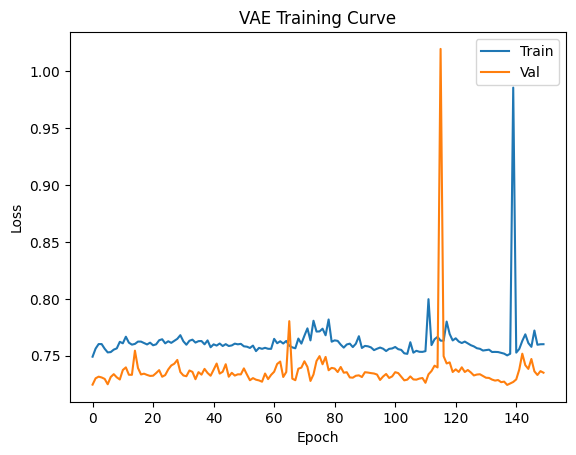

In [14]:
import matplotlib.pyplot as plt

plt.plot(history["train"], label="Train")
plt.plot(history["val"], label="Val")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("VAE Training Curve")
plt.show()

In [15]:
model.load_state_dict(torch.load("models/vae_uci.pt"))
model.eval()

with torch.no_grad():
    z = torch.randn(100, 128, device=DEVICE)
    logits = model.decode_logits(z)
    probs = torch.softmax(logits, dim=-1)
    idx = probs.argmax(dim=-1).cpu().numpy()

bases = np.array(list("ACGT"))
seqs = ["".join(bases[i]) for i in idx]

print("Example generated sequence:")
print(seqs[0][:100], "...")

Example generated sequence:
AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA ...


In [16]:
def gc_content(seq):
    return (seq.count('G') + seq.count('C')) / len(seq)

def homopolymer(seq):
    longest, curr = 1, 1
    for i in range(1, len(seq)):
        if seq[i] == seq[i-1]:
            curr += 1
            longest = max(longest, curr)
        else:
            curr = 1
    return longest

gc_vals = [gc_content(s) for s in seqs]
runs = [homopolymer(s) for s in seqs]

print(f"Avg GC%: {np.mean(gc_vals):.3f}")
print(f"Avg longest homopolymer: {np.mean(runs):.2f}")

Avg GC%: 0.000
Avg longest homopolymer: 199.94


In [31]:
bases = np.array(list("ACGT"))

xb = next(iter(val_dl))[0][:5].to(DEVICE)
model.eval()
with torch.no_grad():
    logits, _, _, _ = model(xb)
pred_idx = logits.argmax(-1).cpu().numpy()
true_idx = xb.argmax(-1).cpu().numpy()

for i in range(5):
    print(f"\nSample {i+1}")
    print("True :", "".join(bases[true_idx[i]]))
    print("Recon:", "".join(bases[pred_idx[i]]))


Sample 1
True : TGTTGATTTTCCATGCGGTGTTTTGCGCAATGTTAATCGCTTTGTACACCTCAGGCAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA
Recon: AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA

Sample 2
True : ATTACAAAAAGTGCTTTCTGAACTGAACAAAAAAGAGTAAAGTTAGTCGCGTAGGGTAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA
Recon: AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA

Sample 3
True : TTACGTTGGCGACCGCTAGGACTTTCTTGTTGATTTTCCATGCGGTGTTTTGCGCAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA

TRY 2

In [17]:
import os, re, numpy as np, torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, random_split
from pathlib import Path
from tqdm import tqdm
import math

# set device
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", DEVICE)

Using device: cuda


In [20]:
DATA_PATH = Path("C:/Users/Akshat/Desktop/Hopkins/Fall_2025/Computational_genomics/Project/Cancer-Tumor-promoter-Generation/data/raw/promoters.data")

def parse_uci_lines(lines):
    pairs = []
    for line in lines:
        line = line.strip()
        if not line or line.startswith("#"):
            continue
        try:
            lab, name, seq = line.split(",", 2)
        except:
            continue
        seq = seq.replace("\t", "").strip().upper()
        seq = re.sub(r"[^ACGT]", "A", seq)
        label = 1 if lab == "+" else 0
        pairs.append((label, seq))
    return pairs

if DATA_PATH.exists():
    pairs = parse_uci_lines(DATA_PATH.read_text().splitlines())
    print(f"Parsed {len(pairs)} sequences from {DATA_PATH}")
    print("Example:", pairs[0])
else:
    raise FileNotFoundError("promoters.data file not found.")

Parsed 106 sequences from C:\Users\Akshat\Desktop\Hopkins\Fall_2025\Computational_genomics\Project\Cancer-Tumor-promoter-Generation\data\raw\promoters.data
Example: (1, 'TACTAGCAATACGCTTGCGTTCGGTGGTTAAGTATGTATAATGCGCGGGCTTGTCGT')


In [21]:
import re, numpy as np
from pathlib import Path

L = 57  # window length for Phase 1
base2idx = {"A":0, "C":1, "G":2, "T":3}

def one_hot_and_mask(seq, L=200):
    s = re.sub(r"[^ACGTacgt]", "A", seq).upper()[:L]  # truncate, don't pad with A
    x = np.zeros((L,4), dtype=np.float32)
    m = np.zeros((L,),   dtype=np.float32)
    for i,ch in enumerate(s):
        x[i, base2idx[ch]] = 1.0
        m[i] = 1.0
    return x, m

X_list, M_list, y_list = [], [], []
for lab, seq in pairs:
    x, m = one_hot_and_mask(seq, L=L)
    X_list.append(x); M_list.append(m); y_list.append(lab)

X = np.stack(X_list).astype("float32")  # [N,L,4]
M = np.stack(M_list).astype("float32")  # [N,L]
y = np.array(y_list)

Path("data/processed").mkdir(parents=True, exist_ok=True)
np.savez_compressed("data/processed/uci_promoters_masked.npz", X=X, M=M, y=y)
X.shape, M.shape, y.shape, M.sum(axis=1).mean()

((106, 57, 4), (106, 57), (106,), np.float32(57.0))

In [22]:
PROC_PATH = Path("data/processed")
PROC_PATH.mkdir(parents=True, exist_ok=True)
np.savez_compressed(PROC_PATH / "uci_promoters_masked.npz", X=X, M=M, y=y)
print("Saved dataset →", PROC_PATH / "uci_promoters_masked.npz")

Saved dataset → data\processed\uci_promoters_masked.npz


In [23]:
import torch
from torch.utils.data import TensorDataset, DataLoader, random_split

dat = np.load("data/processed/uci_promoters_masked.npz")
Xt = torch.from_numpy(dat["X"])   # [N,L,4] float32 (0/1 only at real positions)
Mt = torch.from_numpy(dat["M"])   # [N,L]   float32 (1=real, 0=pad)

ds = TensorDataset(Xt, Mt)
n_val = max(1, int(0.15 * len(ds)))
n_train = len(ds) - n_val
train_ds, val_ds = random_split(ds, [n_train, n_val], generator=torch.Generator().manual_seed(42))

BATCH = 32
train_dl = DataLoader(train_ds, batch_size=BATCH, shuffle=True, drop_last=False)
val_dl   = DataLoader(val_ds,   batch_size=BATCH, shuffle=False, drop_last=False)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE, len(train_ds), len(val_ds)

('cuda', 91, 15)

In [24]:
import torch.nn as nn
import torch.nn.functional as F

class ConvVAE(nn.Module):
    def __init__(self, L=57, z_dim=64, base_c=32):
        super().__init__()
        self.L = L
        self.z_dim = z_dim

        # Encoder
        self.enc = nn.Sequential(
            nn.Conv1d(4, base_c, 7, padding=3), nn.ReLU(),
            nn.Conv1d(base_c, base_c*2, 5, padding=2), nn.ReLU(),
            nn.AdaptiveAvgPool1d(1)
        )
        self.mu     = nn.Linear(base_c*2, z_dim)
        self.logvar = nn.Linear(base_c*2, z_dim)

        # Decoder (a bit deeper)
        self.fc  = nn.Linear(z_dim, base_c*2)
        self.dec = nn.Sequential(
            nn.Conv1d(base_c*2, base_c, 7, padding=3), nn.ReLU(),
            nn.Conv1d(base_c, base_c, 5, padding=2),   nn.ReLU(),
            nn.Conv1d(base_c, 4, 1)                    # logits per base
        )

    def encode(self, x):                      # x: [B,L,4]
        h = self.enc(x.transpose(1,2)).squeeze(-1)  # [B,2c]
        return self.mu(h), self.logvar(h)

    def reparam(self, mu, logvar, sample=True):
        if not sample:
            return mu
        std = (0.5*logvar).exp()
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode_logits(self, z):               # z: [B,z]
        h = self.fc(z).unsqueeze(-1).repeat(1,1,self.L)  # [B,2c,L]
        return self.dec(h).transpose(1,2)                 # [B,L,4]

    def forward(self, x, sample=True):
        mu, logvar = self.encode(x)
        z = self.reparam(mu, logvar, sample=sample)
        logits = self.decode_logits(z)
        return logits, z, mu, logvar

In [25]:
import math, torch

# Reverse-complement augmentation on one-hot [B,L,4]
def reverse_complement_onehot(x):  # x in {0,1}, float ok
    # swap channels A<->T (0<->3), C<->G (1<->2), and reverse along length
    x_rc = x.flip(dims=[1]).clone()  # reverse length
    x_rc = x_rc[..., [3,2,1,0]]      # swap channels
    return x_rc

# Masked cross-entropy (only real bases contribute)
def masked_ce_recon(logits, x, mask):
    # logits: [B,L,4], x: [B,L,4] one-hot, mask: [B,L]
    target_idx = x.argmax(dim=-1)        # [B,L]
    ce = F.cross_entropy(
        logits.reshape(-1,4),
        target_idx.reshape(-1),
        reduction='none'
    ).reshape(target_idx.shape)          # [B,L]
    denom = mask.sum() + 1e-8
    return (ce * mask).sum() / denom

# Small entropy bonus to avoid single-base collapse
def entropy_bonus(logits, mask, weight=1e-3):
    # encourage per-position entropy (discourage peaky all-one-base)
    p = F.softmax(logits, dim=-1)                    # [B,L,4]
    ent = -(p * (p.clamp_min(1e-8)).log()).sum(-1)  # [B,L]
    denom = mask.sum() + 1e-8
    return -weight * (ent * mask).sum() / denom     # negative: we SUBTRACT entropy

def kl_gaussian(mu, logvar):
    return -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())

def kl_anneal(epoch, total=80, beta_max=0.1):
    return min(beta_max, beta_max * (epoch / max(1,total)))

In [26]:
# Adjust model + optimizer for 57 bp data
model = ConvVAE(L=57, z_dim=64, base_c=32).to(DEVICE)

# slightly slower learning rate for stability
opt = torch.optim.AdamW(model.parameters(), lr=3e-3, weight_decay=1e-4)
CLIP = 1.0

EPOCHS_PRE = 120   # longer AE warm-up since dataset is tiny
EPOCHS_VAE = 150   # same fine-tune length

best_val = float("inf")
Path("models").mkdir(parents=True, exist_ok=True)

print("\n== Phase 1: Autoencoder warm-up (deterministic z, masked CE + entropy bonus) ==")
for epoch in range(1, EPOCHS_PRE + 1):
    model.train()
    tr = 0.0
    for xb, mb in train_dl:
        xb, mb = xb.to(DEVICE), mb.to(DEVICE)

        # --- reverse complement + light noise augmentation ---
        if torch.rand(1).item() < 0.5:
            xb = reverse_complement_onehot(xb)
        xb = (xb + 0.05 * torch.randn_like(xb)).clamp(0, 1)

        # deterministic forward pass
        logits, z, mu, logvar = model(xb, sample=False)
        recon = masked_ce_recon(logits, xb, mb)
        entro = entropy_bonus(logits, mb, weight=1e-3)
        loss = recon + entro

        opt.zero_grad(set_to_none=True)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), CLIP)
        opt.step()
        tr += loss.item() * xb.size(0)
    tr /= len(train_dl.dataset)

    # ---- validation ----
    model.eval()
    va = 0.0
    with torch.no_grad():
        for xb, mb in val_dl:
            xb, mb = xb.to(DEVICE), mb.to(DEVICE)
            logits, z, mu, logvar = model(xb, sample=False)
            recon = masked_ce_recon(logits, xb, mb)
            entro = entropy_bonus(logits, mb, weight=1e-3)
            va += (recon + entro).item() * xb.size(0)
    va /= len(val_dl.dataset)

    print(f"Pre {epoch:03d} | train={tr:.4f} | val={va:.4f}")

print("\n== Phase 2: VAE fine-tune (masked CE + β·KL + entropy bonus) ==")
for epoch in range(1, EPOCHS_VAE + 1):
    beta = kl_anneal(epoch, total=80, beta_max=0.05)  # gentler KL schedule
    model.train()
    tr = 0.0

    for xb, mb in train_dl:
        xb, mb = xb.to(DEVICE), mb.to(DEVICE)
        if torch.rand(1).item() < 0.5:
            xb = reverse_complement_onehot(xb)
        xb = (xb + 0.05 * torch.randn_like(xb)).clamp(0, 1)

        logits, z, mu, logvar = model(xb, sample=True)
        recon = masked_ce_recon(logits, xb, mb)
        kl = kl_gaussian(mu, logvar)
        entro = entropy_bonus(logits, mb, weight=1e-3)
        loss = recon + beta * kl + entro

        opt.zero_grad(set_to_none=True)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), CLIP)
        opt.step()
        tr += loss.item() * xb.size(0)
    tr /= len(train_dl.dataset)

    # ---- validation ----
    model.eval()
    va = 0.0
    with torch.no_grad():
        for xb, mb in val_dl:
            xb, mb = xb.to(DEVICE), mb.to(DEVICE)
            logits, z, mu, logvar = model(xb, sample=True)
            recon = masked_ce_recon(logits, xb, mb)
            kl = kl_gaussian(mu, logvar)
            entro = entropy_bonus(logits, mb, weight=1e-3)
            va += (recon + beta * kl + entro).item() * xb.size(0)
    va /= len(val_dl.dataset)

    print(f"VAE {epoch:03d} | train={tr:.4f} | val={va:.4f} | β={beta:.3f}")

    if va < best_val:
        best_val = va
        torch.save(model.state_dict(), "models/vae_promoter_57bp.pt")
        print(f"✅ Saved best (val={best_val:.4f})")


== Phase 1: Autoencoder warm-up (deterministic z, masked CE + entropy bonus) ==
Pre 001 | train=1.3889 | val=1.3805
Pre 002 | train=1.3820 | val=1.3809
Pre 003 | train=1.3827 | val=1.3821
Pre 004 | train=1.3804 | val=1.3826
Pre 005 | train=1.3835 | val=1.3810
Pre 006 | train=1.3813 | val=1.3787
Pre 007 | train=1.3792 | val=1.3757
Pre 008 | train=1.3775 | val=1.3725
Pre 009 | train=1.3754 | val=1.3680
Pre 010 | train=1.3742 | val=1.3720
Pre 011 | train=1.3777 | val=1.3681
Pre 012 | train=1.3720 | val=1.3690
Pre 013 | train=1.3716 | val=1.3716
Pre 014 | train=1.3726 | val=1.3684
Pre 015 | train=1.3715 | val=1.3678
Pre 016 | train=1.3696 | val=1.3679
Pre 017 | train=1.3707 | val=1.3680
Pre 018 | train=1.3710 | val=1.3672
Pre 019 | train=1.3689 | val=1.3670
Pre 020 | train=1.3693 | val=1.3679
Pre 021 | train=1.3700 | val=1.3683
Pre 022 | train=1.3686 | val=1.3690
Pre 023 | train=1.3704 | val=1.3689
Pre 024 | train=1.3692 | val=1.3683
Pre 025 | train=1.3688 | val=1.3680
Pre 026 | train=1.3

In [27]:
bases = np.array(list("ACGT"))
xb, mb = next(iter(val_dl))
xb = xb.to(DEVICE)
model.load_state_dict(torch.load("models/vae_promoter_57bp.pt", map_location=DEVICE))
model.eval()

with torch.no_grad():
    logits, _, _, _ = model(xb)
pred_idx = logits.argmax(-1).cpu().numpy()
true_idx = xb.argmax(-1).cpu().numpy()

for i in range(3):
    print(f"\nSample {i+1}")
    print("True :", "".join(bases[true_idx[i]][:120]))
    print("Recon:", "".join(bases[pred_idx[i]][:120]))


Sample 1
True : TGTTGATTTTCCATGCGGTGTTTTGCGCAATGTTAATCGCTTTGTACACCTCAGGCA
Recon: TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTCCCTT

Sample 2
True : ATTACAAAAAGTGCTTTCTGAACTGAACAAAAAAGAGTAAAGTTAGTCGCGTAGGGT
Recon: AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA

Sample 3
True : TTACGTTGGCGACCGCTAGGACTTTCTTGTTGATTTTCCATGCGGTGTTTTGCGCAA
Recon: CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCTT


In [28]:
from collections import Counter
counts = Counter("".join(seq for _, seq in pairs))
{b: counts[b]/sum(counts.values()) for b in "ACGT"}

{'A': 0.26067527308838134,
 'C': 0.22922873220787818,
 'G': 0.2267461105594174,
 'T': 0.28334988414432305}

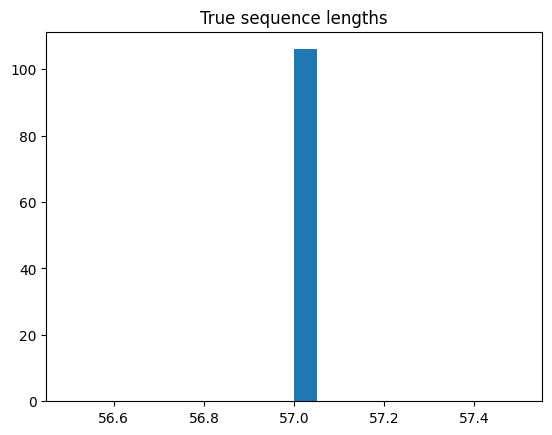

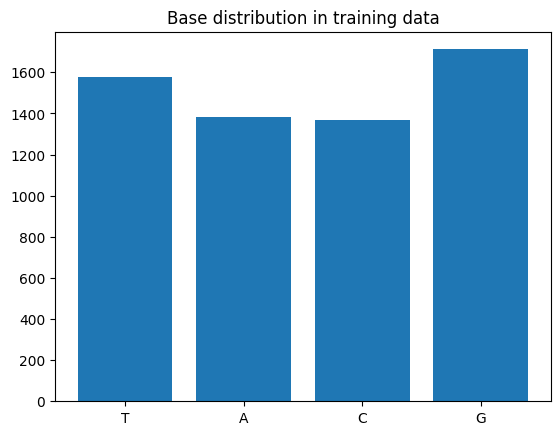

In [29]:
import matplotlib.pyplot as plt

lengths = [m.sum() for m in M]
plt.hist(lengths, bins=20); plt.title("True sequence lengths"); plt.show()

counts = Counter("".join(seq for _, seq in pairs))
plt.bar(counts.keys(), [counts[k] for k in "ACGT"])
plt.title("Base distribution in training data"); plt.show()

Try 3

In [30]:
# === Cell 1: Setup & Imports ===
import os, re, math, random, numpy as np
from pathlib import Path

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, random_split

from tqdm import tqdm

# Reproducibility
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", DEVICE)

Device: cuda


In [32]:
# === Cell 2: Parse UCI promoters and re-encode to 57 bp ===
DATA_PATH = Path("C:/Users/Akshat/Desktop/Hopkins/Fall_2025/Computational_genomics/Project/Cancer-Tumor-promoter-Generation/data/raw/promoters.data")
assert DATA_PATH.exists(), f"Missing file: {DATA_PATH}"

def parse_uci_lines(lines):
    pairs = []
    for line in lines:
        line = line.strip()
        if not line or line.startswith("#"): 
            continue
        # Format: "+,GENE,sequence" or "-,GENE,sequence"
        try:
            lab, gene, seq = line.split(",", 2)
        except:
            continue
        seq = seq.replace("\t", "").strip().upper()
        seq = re.sub(r"[^ACGT]", "A", seq)
        label = 1 if lab == "+" else 0
        pairs.append((label, seq))
    return pairs

pairs = parse_uci_lines(DATA_PATH.read_text().splitlines())
print(f"Parsed {len(pairs)} sequences")
print("Example:", pairs[0])

Parsed 106 sequences
Example: (1, 'TACTAGCAATACGCTTGCGTTCGGTGGTTAAGTATGTATAATGCGCGGGCTTGTCGT')


In [33]:
# === Cell 3: One-hot encode to L=57 with mask ===
L = 57  # actual observed length in this dataset

base2idx = {"A":0, "C":1, "G":2, "T":3}

def one_hot_and_mask(seq, L=57):
    s = seq[:L]                      # truncate to 57
    x = np.zeros((L,4), dtype=np.float32)
    m = np.zeros((L,),  dtype=np.float32)
    for i,ch in enumerate(s):
        x[i, base2idx[ch]] = 1.0
        m[i] = 1.0
    return x, m

X_list, M_list, y_list = [], [], []
for lab, seq in pairs:
    x, m = one_hot_and_mask(seq, L=L)
    X_list.append(x); M_list.append(m); y_list.append(lab)

X = np.stack(X_list).astype("float32")  # [N,57,4]
M = np.stack(M_list).astype("float32")  # [N,57]
y = np.array(y_list)

print("Shapes:", X.shape, M.shape, y.shape)
print("All mask rows sum to:", M.sum(axis=1)[:5], "(should be 57s)")

Shapes: (106, 57, 4) (106, 57) (106,)
All mask rows sum to: [57. 57. 57. 57. 57.] (should be 57s)


In [35]:
# === Cell 4: Save/Load processed arrays & DataLoaders ===
Path("data/processed").mkdir(parents=True, exist_ok=True)
np.savez_compressed("data/processed/uci_57bp.npz", X=X, M=M, y=y)
print("Saved → data/processed/uci_57bp.npz")

dat = np.load("data/processed/uci_57bp.npz")
Xt = torch.from_numpy(dat["X"])  # [N,57,4] float32
Mt = torch.from_numpy(dat["M"])  # [N,57]   float32

ds = TensorDataset(Xt, Mt)
n_val = max(1, int(0.15 * len(ds)))
n_train = len(ds) - n_val
train_ds, val_ds = random_split(ds, [n_train, n_val], generator=torch.Generator().manual_seed(42))

BATCH = 16
train_dl = DataLoader(train_ds, batch_size=BATCH, shuffle=True,  drop_last=False)
val_dl   = DataLoader(val_ds,   batch_size=BATCH, shuffle=False, drop_last=False)

print(f"Train={len(train_ds)}  Val={len(val_ds)}  Batch={BATCH}  L={Xt.shape[1]}")

Saved → data/processed/uci_57bp.npz
Train=91  Val=15  Batch=16  L=57


In [36]:
# === Cell 5: Tiny Transformer Autoencoder ===
class TinyTransformerAE(nn.Module):
    def __init__(self, L=57, emb_dim=32, nhead=4, depth=2, ff_dim=64, p_drop=0.1):
        super().__init__()
        self.L = L
        self.embed = nn.Linear(4, emb_dim)
        self.pos   = nn.Parameter(torch.randn(1, L, emb_dim))
        enc_layer  = nn.TransformerEncoderLayer(
            d_model=emb_dim, nhead=nhead, dim_feedforward=ff_dim,
            dropout=p_drop, batch_first=True, norm_first=True
        )
        self.encoder = nn.TransformerEncoder(enc_layer, num_layers=depth)
        self.dec = nn.Sequential(
            nn.Linear(emb_dim, ff_dim),
            nn.ReLU(),
            nn.Dropout(p_drop),
            nn.Linear(ff_dim, 4)          # logits per base
        )

        # zero-init final layer helps avoid constant-base bias at start
        nn.init.zeros_(self.dec[-1].weight)
        nn.init.zeros_(self.dec[-1].bias)

    def forward(self, x):  # x: [B,L,4] one-hot
        h = self.embed(x) + self.pos     # [B,L,emb]
        h = self.encoder(h)              # [B,L,emb]
        logits = self.dec(h)             # [B,L,4]
        return logits

model = TinyTransformerAE(L=L, emb_dim=32, nhead=4, depth=2, ff_dim=64, p_drop=0.2).to(DEVICE)
n_params = sum(p.numel() for p in model.parameters())
print(f"Model params: {n_params/1e3:.1f}K")

Model params: 21.4K


C:\Users\Akshat\AppData\Roaming\Python\Python313\site-packages\torch\nn\modules\transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


In [37]:
# === Cell 6: Train loop (masked cross-entropy) ===
def masked_ce(logits, x, mask):
    # logits: [B,L,4], x one-hot [B,L,4], mask [B,L]
    target = x.argmax(-1)                              # [B,L]
    loss = F.cross_entropy(logits.reshape(-1,4),
                           target.reshape(-1),
                           reduction='none').reshape(target.shape)  # [B,L]
    return (loss * mask).sum() / (mask.sum() + 1e-8)

opt = torch.optim.AdamW(model.parameters(), lr=1e-2, weight_decay=1e-3)
EPOCHS = 300
best = float('inf')
Path("models").mkdir(parents=True, exist_ok=True)

MASK_PROB = 0.1  # mask 20% of bases each batch

def apply_mask(x, m, mask_prob=MASK_PROB):
    x = x.clone()
    mask = torch.rand_like(m) < mask_prob
    for i in range(x.size(0)):
        x[i][mask[i]] = torch.tensor([0.25, 0.25, 0.25, 0.25], device=x.device)
    return x, mask

for epoch in range(1, EPOCHS+1):
    model.train(); tr = 0.0
    for xb, mb in train_dl:
        xb, mb = xb.to(DEVICE), mb.to(DEVICE)

        # randomly mask 20% of bases
        xb_masked, mask_idx = apply_mask(xb, mb)
        logits = model(xb_masked)
        
        loss = masked_ce(logits, xb, mb * mask_idx.float())  # only predict masked sites
        
        opt.zero_grad()
        loss.backward()
        opt.step()
        tr += loss.item() * xb.size(0)
    tr /= len(train_dl.dataset)
    
    # val (same logic)
    model.eval(); va = 0.0
    with torch.no_grad():
        for xb, mb in val_dl:
            xb, mb = xb.to(DEVICE), mb.to(DEVICE)
            xb_masked, mask_idx = apply_mask(xb, mb)
            logits = model(xb_masked)
            va += masked_ce(logits, xb, mb * mask_idx.float()).item() * xb.size(0)
    va /= len(val_dl.dataset)

    if va < best:
        best = va
        torch.save(model.state_dict(), "models/transformer_promoter_masked.pt")

    if epoch % 20 == 0 or epoch == 1:
        print(f"Epoch {epoch:03d} | train={tr:.4f} | val={va:.4f} | best={best:.4f}")

Epoch 001 | train=1.3948 | val=1.4038 | best=1.4038
Epoch 020 | train=1.3762 | val=1.4006 | best=1.3664
Epoch 040 | train=1.3867 | val=1.3747 | best=1.3504
Epoch 060 | train=1.3634 | val=1.3790 | best=1.3476
Epoch 080 | train=1.3725 | val=1.3941 | best=1.3324
Epoch 100 | train=1.3597 | val=1.3733 | best=1.3324
Epoch 120 | train=1.3821 | val=1.4247 | best=1.3105
Epoch 140 | train=1.3826 | val=1.3724 | best=1.3105
Epoch 160 | train=1.3652 | val=1.3755 | best=1.3105
Epoch 180 | train=1.3745 | val=1.3888 | best=1.3105
Epoch 200 | train=1.3774 | val=1.3798 | best=1.3105
Epoch 220 | train=1.3785 | val=1.4829 | best=1.3105
Epoch 240 | train=1.3853 | val=1.3877 | best=1.3105
Epoch 260 | train=1.3808 | val=1.3942 | best=1.3105
Epoch 280 | train=1.3827 | val=1.3897 | best=1.3105
Epoch 300 | train=1.3797 | val=1.3884 | best=1.3105


In [42]:
# === Cell 7: Reconstructions ===
bases = np.array(list("ACGT"))
model.load_state_dict(torch.load("models/transformer_promoter_masked.pt", map_location=DEVICE))
model.eval()

xb, mb = next(iter(val_dl))
xb = xb.to(DEVICE)
with torch.no_grad():
    logits = model(xb)
pred_idx = logits.argmax(-1).cpu().numpy()
true_idx = xb.argmax(-1).cpu().numpy()

for i in range(min(5, xb.size(0))):
    print(f"\nSample {i+1}")
    print("True :", "".join(bases[true_idx[i]]))
    print("Recon:", "".join(bases[pred_idx[i]]))


Sample 1
True : TGTTGATTTTCCATGCGGTGTTTTGCGCAATGTTAATCGCTTTGTACACCTCAGGCA
Recon: ATTTAAATCTCGTTTTGCCATTCGTGTTGTATTTTTTTTAATTTTCTTCCACATTTT

Sample 2
True : ATTACAAAAAGTGCTTTCTGAACTGAACAAAAAAGAGTAAAGTTAGTCGCGTAGGGT
Recon: ATTTAAATAAAGTTTTGCCATTGGTGTTGTATTTTTTTTATTTTTCTTCCCCTTATT

Sample 3
True : TTACGTTGGCGACCGCTAGGACTTTCTTGTTGATTTTCCATGCGGTGTTTTGCGCAA
Recon: ATTTAAATAACGTTTTGCCATTCGTGTTGTATTTTTTTTAATTTACTTTCACATTTT

Sample 4
True : CTGCAATTTTTCTATTGCGGCCTGCGGAGAACTCCCTATAATGCGCCTCCATCGACA
Recon: CTTTAAATAACGTTTTGCCAGTCTTGTTGTATTTTTTTTATTATACTTCCACATTTT

Sample 5
True : AGGAGGAACTACGCAAGGTTGGAACATCGGAGAGATGCCAGCCAGCGCACCTGCACG
Recon: ATTTAAATAACGTTTTGCCATTTTTGTTGTATTTTTTTTAATTTTCTTTCATATTTA


In [43]:
# === Cell 8 (Optional): Denoising variants ===
model.eval()
xb, mb = next(iter(train_dl))
xb = xb.to(DEVICE)
with torch.no_grad():
    noisy = (xb + 0.10*torch.randn_like(xb)).clamp(0,1)
    logits = model(noisy)
    idx = logits.argmax(-1).cpu().numpy()

gen = ["".join(bases[i]) for i in idx]
print("\nGenerated (denoised) variants from a mini-batch:")
for s in gen[:3]:
    print(s)


Generated (denoised) variants from a mini-batch:
ATTTAAATAACGTTTTGCCATTGTTGTTGTATTTTTTTTATTTTTCTTTCACATTTT
ATTTAAATAACGTTTTGCCATTTATGTTGTATTTTTTATATTATTCTTTCCCATTTT
ATTTAATTAAAGTTTTGCCATTGTTGTTGTATTTTTTTTAATTTTCTTTCCCTTTTT


In [44]:
MASK_PROB = 0.2

def apply_mask(x, m, mask_prob=MASK_PROB):
    x = x.clone()
    mask = torch.rand_like(m) < mask_prob
    for i in range(x.size(0)):
        x[i][mask[i]] = torch.tensor([0.25,0.25,0.25,0.25], device=x.device)
    return x, mask

model.eval()
xb, mb = next(iter(val_dl))
xb, mb = xb.to(DEVICE), mb.to(DEVICE)
xb_masked, mask_idx = apply_mask(xb, mb)

with torch.no_grad():
    logits = model(xb_masked)
pred_idx = logits.argmax(-1).cpu().numpy()
true_idx = xb.argmax(-1).cpu().numpy()
masked = mask_idx.cpu().numpy()

bases = np.array(list("ACGT"))
for i in range(3):
    true = "".join(bases[true_idx[i]])
    recon = "".join(bases[pred_idx[i]])
    mask_visual = "".join(["░" if masked[i,j] else true[j] for j in range(L)])
    print(f"\nSample {i+1}\nMasked: {mask_visual}\nRecon : {recon}\nTrue  : {true}")


Sample 1
Masked: T░░TGATTTTCCATG░GGTGT░T░GCGC░ATGTTAATCGCTTTGTA░A░░░CA░GCA
Recon : ATTTAAATCTCGTTTTGCCATTCTTGTTGTATTTTTTTTAATTTTCTTTCACATTTT
True  : TGTTGATTTTCCATGCGGTGTTTTGCGCAATGTTAATCGCTTTGTACACCTCAGGCA

Sample 2
Masked: ATTACAAA░░GTG░TTTCTG░ACTGAAC░░AAAAGAGTAAAGTTAGTCGCGTA░GGT
Recon : ATTTAAATAAAGTTTTGCCATTGGTGTTGTATTTTTTTTATTTTTCTTTCCCTTATT
True  : ATTACAAAAAGTGCTTTCTGAACTGAACAAAAAAGAGTAAAGTTAGTCGCGTAGGGT

Sample 3
Masked: TT░░GTT░GCGACCG░TAG░AC░TTCTT░TT░ATTTTCC░TGCG░TG░░TTG░GCAA
Recon : ATTTAAATAACGTTTTGCCATTGTTGTTGTATTTTTTATATTTTTCTTTCACATTTT
True  : TTACGTTGGCGACCGCTAGGACTTTCTTGTTGATTTTCCATGCGGTGTTTTGCGCAA


In [46]:
def base_accuracy(model, dataloader):
    model.eval()
    total, correct = 0, 0
    with torch.no_grad():
        for xb, mb in dataloader:
            xb, mb = xb.to(DEVICE), mb.to(DEVICE)
            logits = model(xb)
            pred = logits.argmax(-1)
            true = xb.argmax(-1)
            mask = mb.bool()
            correct += (pred[mask] == true[mask]).sum().item()
            total += mask.sum().item()
    return correct / total

acc = base_accuracy(model, val_dl)
print(f"Base Accuracy on Validation: {acc:.3f}")

Base Accuracy on Validation: 0.292


In [48]:
import math
def perplexity(model, dataloader):
    model.eval()
    nll, n_bases = 0.0, 0
    with torch.no_grad():
        for xb, mb in dataloader:
            xb, mb = xb.to(DEVICE), mb.to(DEVICE)
            logits = model(xb)
            target = xb.argmax(-1)
            loss = F.cross_entropy(
                logits.reshape(-1,4),
                target.reshape(-1),
                reduction='none'
            ).reshape(target.shape)
            nll += (loss * mb).sum().item()
            n_bases += mb.sum().item()
    ppl = math.exp(nll / n_bases)
    return ppl

ppl = perplexity(model, val_dl)
print(f"Perplexity: {ppl:.2f}")

Perplexity: 4.03


In [49]:
from collections import Counter

def gc_content(seq): return (seq.count("G")+seq.count("C"))/len(seq)

def kmer_freqs(seqs, k=3):
    counts = Counter()
    for s in seqs:
        for i in range(len(s)-k+1):
            counts[s[i:i+k]] += 1
    total = sum(counts.values())
    for kmer in counts: counts[kmer] /= total
    return counts

# True vs reconstructed
bases = np.array(list("ACGT"))
true_seqs = ["".join(bases[x.argmax(-1).cpu().numpy()]) for x,_ in val_dl.dataset]
model.eval()
with torch.no_grad():
    recon_logits = model(torch.stack([x for x,_ in val_dl.dataset]).to(DEVICE))
recon_seqs = ["".join(bases[p]) for p in recon_logits.argmax(-1).cpu().numpy()]

true_gc = np.mean([gc_content(s) for s in true_seqs])
recon_gc = np.mean([gc_content(s) for s in recon_seqs])
print(f"GC% True={true_gc:.3f}, Recon={recon_gc:.3f}")

# k-mer correlation
from scipy.stats import pearsonr
t3 = kmer_freqs(true_seqs, 3); r3 = kmer_freqs(recon_seqs, 3)
shared = sorted(set(t3) & set(r3))
corr = pearsonr([t3[k] for k in shared],[r3[k] for k in shared])[0]
print(f"3-mer distribution correlation: {corr:.3f}")

GC% True=0.449, Recon=0.218
3-mer distribution correlation: 0.288


In [50]:
import torch, torch.nn.functional as F, numpy as np
from collections import defaultdict

MASK_PROB = 0.2
bases = np.array(list("ACGT"))

def apply_mask(x, m, mask_prob=MASK_PROB):
    x = x.clone()
    mask = torch.rand_like(m) < mask_prob
    # replace masked positions with uniform distribution (no info)
    x[mask] = torch.tensor([0.25,0.25,0.25,0.25], device=x.device)
    return x, mask

def eval_masked_metrics(model, dl, topk=(1,2,3)):
    model.eval()
    total_masked = 0
    correct_at_k = defaultdict(int)
    nll_sum = 0.0

    with torch.no_grad():
        for xb, mb in dl:
            xb, mb = xb.to(DEVICE), mb.to(DEVICE)
            xb_masked, mask_idx = apply_mask(xb, mb)
            logits = model(xb_masked)                       # [B,L,4]
            logp = F.log_softmax(logits, dim=-1)
            target = xb.argmax(-1)                          # [B,L]

            # only consider masked positions
            mask_flat = mask_idx.reshape(-1)
            target_flat = target.reshape(-1)
            logp_flat = logp.reshape(-1, 4)

            if mask_flat.sum() == 0: 
                continue

            # NLL
            nll = -logp_flat[mask_flat, :].gather(1, target_flat[mask_flat].unsqueeze(1)).mean()
            nll_sum += nll.item() * mask_flat.sum().item()

            # top-k
            probs = torch.exp(logp_flat[mask_flat, :])      # [M,4]
            topk_idx = torch.topk(probs, k=max(topk), dim=-1).indices  # [M,K]
            for k in topk:
                correct_at_k[k] += (topk_idx[:, :k] == target_flat[mask_flat].unsqueeze(1)).any(dim=1).sum().item()

            total_masked += mask_flat.sum().item()

    out = {f"top{k}_acc": correct_at_k[k] / total_masked for k in topk}
    out["nll"] = nll_sum / total_masked
    out["ppl"] = float(np.exp(out["nll"]))
    out["masked_frac"] = MASK_PROB
    return out

masked_scores = eval_masked_metrics(model, val_dl, topk=(1,2,3))
print(masked_scores)

{'top1_acc': 0.2710843373493976, 'top2_acc': 0.5240963855421686, 'top3_acc': 0.7710843373493976, 'nll': 1.408839464187622, 'ppl': 4.091204658377315, 'masked_frac': 0.2}


Position-wise masked accuracy (first 20): [0.2   0.    0.333 0.    0.    0.667 1.    0.667 0.333 0.25  0.25  0.
 1.    0.5   0.    0.2   0.5   0.    0.    0.   ]


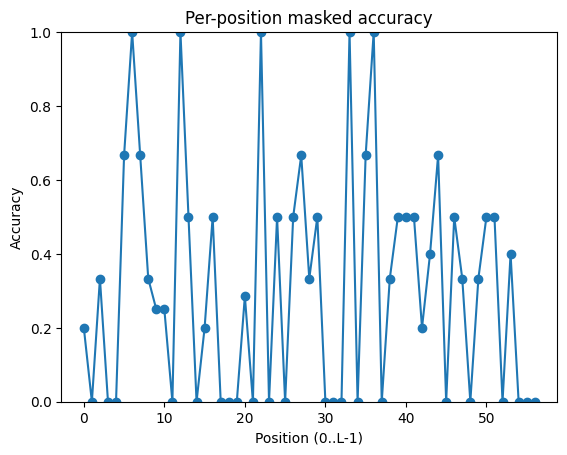

In [51]:
import numpy as np

def per_position_accuracy(model, dl):
    model.eval()
    L = next(iter(dl))[0].shape[1]
    correct = np.zeros(L, dtype=np.int64)
    total   = np.zeros(L, dtype=np.int64)
    with torch.no_grad():
        for xb, mb in dl:
            xb, mb = xb.to(DEVICE), mb.to(DEVICE)
            xb_masked, mask_idx = apply_mask(xb, mb)
            logits = model(xb_masked)
            pred = logits.argmax(-1)        # [B,L]
            true = xb.argmax(-1)
            mask = mask_idx.bool()

            for pos in range(L):
                mpos = mask[:, pos]
                correct[pos] += (pred[mpos, pos] == true[mpos, pos]).sum().item()
                total[pos]   += mpos.sum().item()
    acc = np.divide(correct, np.maximum(total, 1))
    return acc

acc_pos = per_position_accuracy(model, val_dl)
print("Position-wise masked accuracy (first 20):", np.round(acc_pos[:20], 3))

# Quick plot (optional)
import matplotlib.pyplot as plt
plt.plot(acc_pos, marker='o'); plt.ylim(0,1)
plt.title("Per-position masked accuracy"); plt.xlabel("Position (0..L-1)"); plt.ylabel("Accuracy")
plt.show()

In [52]:
import numpy as np

def masked_confusion(model, dl):
    cm = np.zeros((4,4), dtype=np.int64)  # rows=true, cols=pred
    with torch.no_grad():
        for xb, mb in dl:
            xb, mb = xb.to(DEVICE), mb.to(DEVICE)
            xb_masked, mask_idx = apply_mask(xb, mb)
            logits = model(xb_masked)
            pred = logits.argmax(-1)
            true = xb.argmax(-1)
            mask = mask_idx.bool()

            t = true[mask].cpu().numpy().ravel()
            p = pred[mask].cpu().numpy().ravel()
            for ti, pi in zip(t, p): cm[ti, pi] += 1
    return cm

cm = masked_confusion(model, val_dl)
print("Confusion matrix (rows=true A C G T, cols=pred):\n", cm)

Confusion matrix (rows=true A C G T, cols=pred):
 [[11  7  5 30]
 [ 5  3  3 18]
 [ 9  7  5 21]
 [ 4  5  2 32]]


In [53]:
import re

def eval_motif_recall(model, dl, motif="TATAAT", mask_prob=0.2):
    hits_true = hits_recon = 0
    with torch.no_grad():
        for xb, mb in dl:
            xb, mb = xb.to(DEVICE), mb.to(DEVICE)
            xb_masked, mask_idx = apply_mask(xb, mb)
            logits = model(xb_masked)
            pred = logits.argmax(-1).cpu().numpy()
            true = xb.argmax(-1).cpu().numpy()
            for i in range(true.shape[0]):
                t = "".join(bases[true[i]])
                r = "".join(bases[pred[i]])
                hits_true += len(re.findall(motif, t))
                hits_recon += len(re.findall(motif, r))
    return hits_true, hits_recon

for m in ["TATAAT", "TTGACA"]:
    ht, hr = eval_motif_recall(model, val_dl, motif=m, mask_prob=0.2)
    print(f"{m}: true_hits={ht}  recon_hits={hr}  recall≈{hr/max(ht,1):.2f}")

TATAAT: true_hits=2  recon_hits=2  recall≈1.00
TTGACA: true_hits=0  recon_hits=0  recall≈0.00


In [54]:
def calibration_buckets(model, dl, bins=10):
    model.eval()
    bucket_correct = np.zeros(bins)
    bucket_count   = np.zeros(bins)
    with torch.no_grad():
        for xb, mb in dl:
            xb, mb = xb.to(DEVICE), mb.to(DEVICE)
            xb_masked, mask_idx = apply_mask(xb, mb)
            logits = model(xb_masked)
            probs  = torch.softmax(logits, dim=-1)
            top_p, top_i = probs.max(-1)
            true = xb.argmax(-1)
            mask = mask_idx.bool()

            conf = top_p[mask].cpu().numpy().ravel()
            corr = (top_i[mask] == true[mask]).cpu().numpy().ravel()
            idx = np.minimum((conf * bins).astype(int), bins-1)
            for k, c in zip(idx, corr):
                bucket_correct[k] += c
                bucket_count[k]   += 1
    return bucket_correct / np.maximum(bucket_count, 1), bucket_count

acc_b, cnt_b = calibration_buckets(model, val_dl, bins=10)
print("Bucket accuracies:", np.round(acc_b,3))
print("Bucket counts    :", cnt_b.astype(int))

Bucket accuracies: [0.    0.    0.33  0.271 0.583 0.6   0.    0.    0.    0.   ]
Bucket counts    : [  0   0 106  48  12   5   0   0   0   0]


TRY 4

In [55]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
import numpy as np
import random
from tqdm import tqdm

In [56]:
L = 50        # target sequence length (truncate/pad)
Z_DIM = 64    # latent dimension
BATCH_SIZE = 32
LR = 1e-3
EPOCHS = 150

In [58]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DATA_PATH = Path("C:/Users/Akshat/Desktop/Hopkins/Fall_2025/Computational_genomics/Project/Cancer-Tumor-promoter-Generation/data/raw/sequence_data.txt")

In [59]:
base2idx = {'A':0, 'C':1, 'G':2, 'T':3}

def one_hot_encode(seq, L=57):
    x = np.zeros((L, 4), dtype=np.float32)
    m = np.zeros(L, dtype=np.float32)
    for i, ch in enumerate(seq[:L]):
        if ch in base2idx:
            x[i, base2idx[ch]] = 1.0
            m[i] = 1.0
    return x, m

# Load and encode sequences
def load_sequences(path, L=57):
    seqs = [line.strip().upper() for line in open(path) if line.strip()]
    X, M = zip(*(one_hot_encode(s, L) for s in seqs))
    X, M = np.stack(X), np.stack(M)
    print(f"Loaded {len(X)} sequences, shape={X.shape}")
    return X, M

X, M = load_sequences(DATA_PATH, L=L)

# Dataset class
class PromoterDataset(torch.utils.data.Dataset):
    def __init__(self, X, M):
        self.X = torch.tensor(X)
        self.M = torch.tensor(M)
    def __len__(self): return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.M[idx]

# --- Create full dataset ---
full_ds = PromoterDataset(X, M)
n_total = len(full_ds)
n_train = int(0.7 * n_total)
n_val   = int(0.15 * n_total)
n_test  = n_total - n_train - n_val

train_ds, val_ds, test_ds = random_split(
    full_ds, [n_train, n_val, n_test],
    generator=torch.Generator().manual_seed(42)  # reproducibility
)

print(f"Dataset split -> Train: {len(train_ds)}, Val: {len(val_ds)}, Test: {len(test_ds)}")

# --- DataLoaders ---
BATCH_SIZE = 32
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_dl   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)
test_dl  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

Loaded 14098 sequences, shape=(14098, 50, 4)
Dataset split -> Train: 9868, Val: 2114, Test: 2116


In [60]:
class ConvVAE(nn.Module):
    def __init__(self, L=57, z_dim=64, base_c=32):
        super().__init__()
        self.enc = nn.Sequential(
            nn.Conv1d(4, base_c, 5, padding=2), nn.ReLU(),
            nn.Conv1d(base_c, base_c*2, 5, padding=2), nn.ReLU(),
            nn.AdaptiveAvgPool1d(1)
        )
        self.fc_mu = nn.Linear(base_c*2, z_dim)
        self.fc_logvar = nn.Linear(base_c*2, z_dim)

        self.fc_dec = nn.Linear(z_dim, base_c*2*L)
        self.dec = nn.Sequential(
            nn.Conv1d(base_c*2, base_c, 3, padding=1), nn.ReLU(),
            nn.Conv1d(base_c, 4, 1)
        )

    def encode(self, x):
        h = self.enc(x.permute(0,2,1))
        h = h.squeeze(-1)
        return self.fc_mu(h), self.fc_logvar(h)

    def reparam(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = self.fc_dec(z)
        h = h.view(z.size(0), -1, L)
        out = self.dec(h).permute(0,2,1)
        return out

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparam(mu, logvar)
        logits = self.decode(z)
        return logits, mu, logvar

In [61]:
def vae_loss(logits, target, mu, logvar, mask, beta=0.1):
    """
    logits: predicted base logits (B, L, 4)
    target: one-hot encoded true sequence (B, L, 4)
    mu, logvar: latent parameters (B, z_dim)
    mask: binary mask of valid positions (B, L)
    beta: weight for KL term
    """
    B = target.size(0)

    # Cross entropy reconstruction loss
    recon = F.cross_entropy(
        logits.reshape(-1, 4),
        target.argmax(-1).reshape(-1),
        reduction='none'
    )
    recon = (recon * mask.reshape(-1)).sum() / mask.sum()

    # KL divergence between q(z|x) and N(0,1)
    kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / B

    loss = recon + beta * kl
    return loss, recon, kl

In [62]:
model = ConvVAE(L=L, z_dim=Z_DIM).to(DEVICE)
opt = torch.optim.AdamW(model.parameters(), lr=LR)
best_val = float("inf")
Path("models").mkdir(exist_ok=True)

for epoch in range(1, EPOCHS+1):
    model.train()
    total_train = 0
    for xb, mb in train_dl:
        xb, mb = xb.to(DEVICE), mb.to(DEVICE)
        logits, mu, logvar = model(xb)
        loss, recon, kl = vae_loss(logits, xb, mu, logvar, mb)
        opt.zero_grad()
        loss.backward()
        opt.step()
        total_train += loss.item() * xb.size(0)
    train_loss = total_train / len(train_dl.dataset)

    # Validation
    model.eval()
    total_val = 0
    with torch.no_grad():
        for xb, mb in val_dl:
            xb, mb = xb.to(DEVICE), mb.to(DEVICE)
            logits, mu, logvar = model(xb)
            loss, _, _ = vae_loss(logits, xb, mu, logvar, mb)
            total_val += loss.item() * xb.size(0)
    val_loss = total_val / len(val_dl.dataset)

    if val_loss < best_val:
        best_val = val_loss
        torch.save(model.state_dict(), "models/vae_promoter.pt")
    
    print(f"Epoch {epoch:03d} | train={train_loss:.4f} | val={val_loss:.4f} | best={best_val:.4f}")

Epoch 001 | train=1.3681 | val=1.3567 | best=1.3567
Epoch 002 | train=1.3545 | val=1.3526 | best=1.3526
Epoch 003 | train=1.3519 | val=1.3511 | best=1.3511
Epoch 004 | train=1.3509 | val=1.3506 | best=1.3506
Epoch 005 | train=1.3505 | val=1.3498 | best=1.3498
Epoch 006 | train=1.3500 | val=1.3496 | best=1.3496
Epoch 007 | train=1.3498 | val=1.3494 | best=1.3494
Epoch 008 | train=1.3495 | val=1.3490 | best=1.3490
Epoch 009 | train=1.3496 | val=1.3489 | best=1.3489
Epoch 010 | train=1.3493 | val=1.3491 | best=1.3489
Epoch 011 | train=1.3494 | val=1.3489 | best=1.3489
Epoch 012 | train=1.3490 | val=1.3491 | best=1.3489
Epoch 013 | train=1.3491 | val=1.3491 | best=1.3489
Epoch 014 | train=1.3490 | val=1.3487 | best=1.3487
Epoch 015 | train=1.3490 | val=1.3486 | best=1.3486
Epoch 016 | train=1.3489 | val=1.3479 | best=1.3479
Epoch 017 | train=1.3487 | val=1.3483 | best=1.3479
Epoch 018 | train=1.3489 | val=1.3486 | best=1.3479
Epoch 019 | train=1.3487 | val=1.3485 | best=1.3479
Epoch 020 | 

In [126]:
len("ATAGCAGCTTCTGAACTGGTTACCTGCCGTGAGTAAATTAAAATTTTATT")

50

In [64]:
import numpy as np
import torch

# --- load best model checkpoint ---
model.load_state_dict(torch.load("models/vae_promoter.pt", map_location=DEVICE))
model.eval()

# --- generate new promoter-like sequences ---
N_SAMPLES = 10          # number of synthetic sequences to generate
with torch.no_grad():
    z = torch.randn(N_SAMPLES, Z_DIM).to(DEVICE)      # random latent vectors
    logits = model.decode(z)                          # decode into DNA logits
    probs = torch.softmax(logits, dim=-1)
    seqs = torch.argmax(probs, dim=-1).cpu().numpy()  # choose most likely base

# --- convert to readable DNA strings ---
idx2base = np.array(['A','C','G','T'])
generated_seqs = ["".join(idx2base[s]) for s in seqs]

print("✅ Example synthetic promoter sequences:\n")
for i, s in enumerate(generated_seqs, 1):
    print(f"{i:02d}. {s}")

✅ Example synthetic promoter sequences:

01. TTTTTAATAATGTTTTTGAAATTTTTGTTAATTTGGGTTAAATTTATATT
02. TTTTTATTAATTTTTTTGCAAATTTTGTTAATTTGGGTTAAATTTATAAT
03. TTGTTAATAATTTTTTTGCAATTATTGTTAATTTGGGTTATATTTATATT
04. TTTTTAATAATTTTTTTGAAATTTTTGTTAATTTGGGTTAAATTTATAAT
05. TTGTTGATAAATTTTTTGAAAATTTGGGTAATTTGGGTTAAATTTATAAT
06. TTTTTAATAAATTTTTTGACAATTTGGTTAATTTGGGTTAAATTTAAAAT
07. TTGTTAAAAATTTTTTTGCAATTTTTGTTAATTTGGGTTAAATTTATAAT
08. TTGTTAATAATTTTTTTGCAATTTTTGTAAATTTGGGTTAAATTTAAATT
09. TTTTTGATAATGTTTTTGATATTTTTGGTAATTTGGGTTAAATTTATATT
10. TTTTTAAAAAAATTTTTGCAAATTTTGTAAATTTGGGTTAAATTTAAAAT


In [65]:
from pathlib import Path
Path("results").mkdir(exist_ok=True)

with open("results/generated_promoters.fa", "w") as f:
    for i, seq in enumerate(generated_seqs, 1):
        f.write(f">synthetic_{i}\n{seq}\n")

print(f"Saved {len(generated_seqs)} synthetic sequences → results/generated_promoters.fa")

Saved 10 synthetic sequences → results/generated_promoters.fa


In [66]:
def gc_content(seq):
    return (seq.count('G') + seq.count('C')) / len(seq)

def homopolymer(seq):
    longest = curr = 1
    for i in range(1, len(seq)):
        if seq[i] == seq[i-1]:
            curr += 1
            longest = max(longest, curr)
        else:
            curr = 1
    return longest

gc_vals = [gc_content(s) for s in generated_seqs]
homopolymers = [homopolymer(s) for s in generated_seqs]

print(f"Average GC% = {np.mean(gc_vals):.3f}")
print(f"Average longest homopolymer run = {np.mean(homopolymers):.2f}")

Average GC% = 0.136
Average longest homopolymer run = 6.40


In [67]:
# reconstruct real sequences (if X available as one-hot)
idx2base = np.array(['A','C','G','T'])
real_strs = ["".join(idx2base[np.argmax(x, axis=1)]) for x in X[:len(generated_seqs)]]

gc_real = [gc_content(s) for s in real_strs]
gc_gen  = [gc_content(s) for s in generated_seqs]
print(f"Real GC% = {np.mean(gc_real):.3f}, Generated GC% = {np.mean(gc_gen):.3f}")

Real GC% = 0.422, Generated GC% = 0.136


In [68]:
motifs = ["TATAAA", "GGGCGG", "CCAAT", "CACGTG"]

def motif_count(seq, motif):
    return seq.count(motif)

for motif in motifs:
    real_hits = sum(motif_count(s, motif) for s in real_strs)
    gen_hits  = sum(motif_count(s, motif) for s in generated_seqs)
    recall = gen_hits / max(real_hits, 1)
    print(f"{motif}: real={real_hits}, generated={gen_hits}, recall≈{recall:.2f}")

TATAAA: real=0, generated=0, recall≈0.00
GGGCGG: real=0, generated=0, recall≈0.00
CCAAT: real=2, generated=0, recall≈0.00
CACGTG: real=0, generated=0, recall≈0.00


In [69]:
from collections import Counter
from itertools import product
from scipy.stats import pearsonr

def kmer_freqs(seq, k=3):
    kmers = [seq[i:i+k] for i in range(len(seq)-k+1)]
    c = Counter(kmers)
    total = sum(c.values())
    return {kmer: c[kmer]/total for kmer in c}

k = 3
alphabet = ['A','C','G','T']
all_kmers = ["".join(p) for p in product(alphabet, repeat=k)]

real_freqs = np.array([np.mean([kmer_freqs(s, k).get(km, 0) for s in real_strs]) for km in all_kmers])
gen_freqs  = np.array([np.mean([kmer_freqs(s, k).get(km, 0) for s in generated_seqs]) for km in all_kmers])

pcc, _ = pearsonr(real_freqs, gen_freqs)
print(f"{k}-mer distribution correlation (PCC): {pcc:.3f}")

3-mer distribution correlation (PCC): 0.661


In [70]:
import torch
import numpy as np

model.eval()

# number of new sequences to generate
N = 500  

# generate latent codes from normal distribution
z = torch.randn(N, model.fc_mu.out_features).to(DEVICE)

with torch.no_grad():
    logits = model.decode(z)                     # shape: [N, L, 4]
    probs = torch.softmax(logits, dim=-1)
    sampled = torch.argmax(probs, dim=-1).cpu().numpy()

# decode one-hot indices to A/C/G/T strings
idx2nt = np.array(["A", "C", "G", "T"])
gen_sequences = ["".join(idx2nt[s]) for s in sampled]

print(f"Generated {len(gen_sequences)} synthetic promoter sequences.")
print(f"Example generated: {gen_sequences[0][:80]}...")

Generated 500 synthetic promoter sequences.
Example generated: TTTTTATTAATTTTTTTGAAATTTTTGTTAATTTGGGTTAAATTTATAAT...


In [71]:
with open(DATA_PATH) as f:
    real_sequences = [line.strip().upper() for line in f if len(line.strip()) > 0]

# Generated sequences: from your trained VAE
# (replace this with your generated list variable if you already have one)
generated_sequences = gen_sequences  # or whatever variable holds your generated promoters

print(f"Loaded {len(real_sequences)} real and {len(generated_sequences)} generated sequences.")
print(f"Example real: {real_sequences[0][:50]}...")
print(f"Example generated: {generated_sequences[0][:50]}...")

Loaded 14098 real and 500 generated sequences.
Example real: ATAGCAGCTTCTGAACTGGTTACCTGCCGTGAGTAAATTAAAATTTTATT...
Example generated: TTTTTATTAATTTTTTTGAAATTTTTGTTAATTTGGGTTAAATTTATAAT...


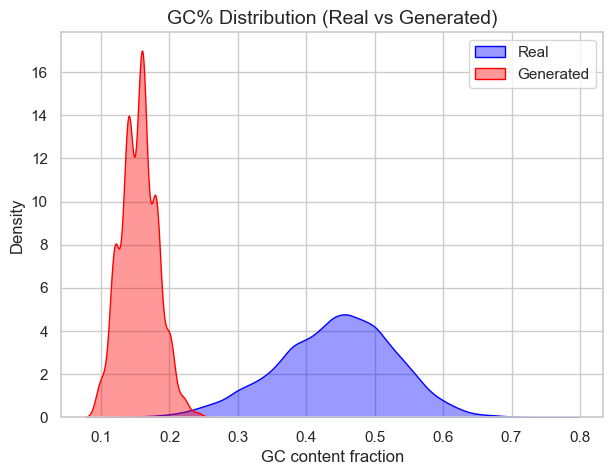

In [155]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

def gc_content(seq):
    seq = seq.upper()
    return (seq.count("G") + seq.count("C")) / len(seq)

# compute GC%
gc_real = [gc_content(s) for s in real_sequences]
gc_gen = [gc_content(s) for s in generated_sequences]

plt.figure(figsize=(7,5))
sns.kdeplot(gc_real, fill=True, color='blue', label='Real', alpha=0.4)
sns.kdeplot(gc_gen, fill=True, color='red', label='Generated', alpha=0.4)
plt.title("GC% Distribution (Real vs Generated)", fontsize=14)
plt.xlabel("GC content fraction")
plt.ylabel("Density")
plt.legend()
plt.show()

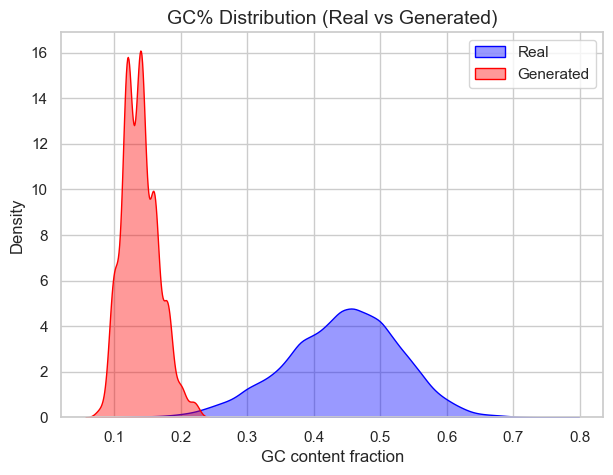

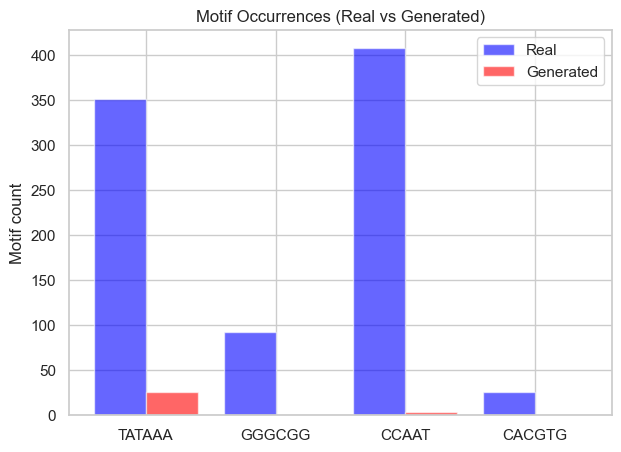

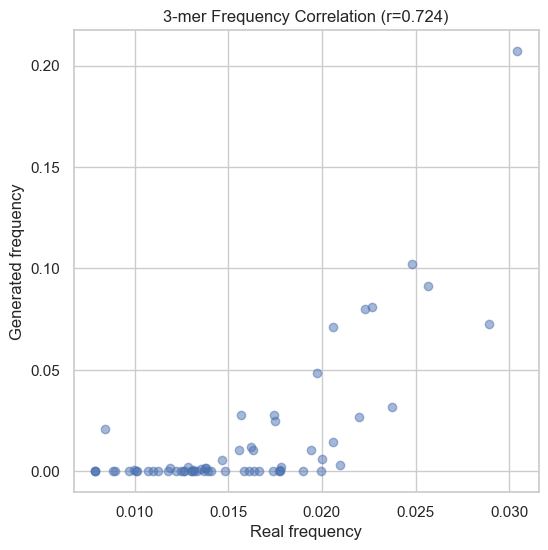

<Figure size 1200x300 with 0 Axes>

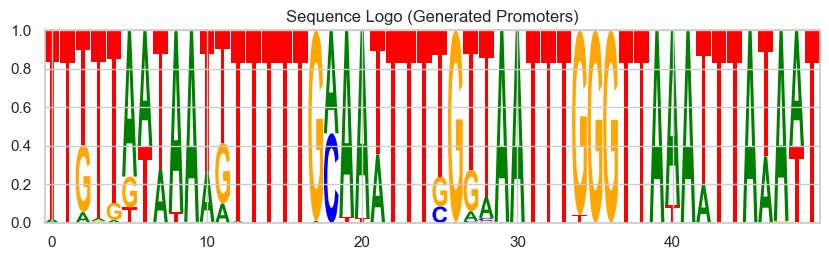


GC% Mean (real): 0.443 | (gen): 0.139
3-mer correlation: 0.724


In [73]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from itertools import product
import pandas as pd
import logomaker

sns.set(style="whitegrid")

# --- Helper functions ---
def gc_content(seq):
    seq = seq.upper()
    return (seq.count("G") + seq.count("C")) / len(seq)

def kmer_freqs(seqs, k=3):
    all_kmers = [''.join(p) for p in product('ACGT', repeat=k)]
    counts = Counter()
    for seq in seqs:
        for i in range(len(seq)-k+1):
            counts[seq[i:i+k]] += 1
    total = sum(counts.values())
    return np.array([counts[km]/total for km in all_kmers]), all_kmers

def onehot_to_df(seqs):
    L = len(seqs[0])
    df = pd.DataFrame(0, index=list("ACGT"), columns=range(L))
    for seq in seqs:
        for i, base in enumerate(seq):
            if base in "ACGT":
                df.loc[base, i] += 1
    df = df.div(df.sum(axis=0), axis=1)
    return df.T

# --- GC content comparison ---
gc_real = [gc_content(s) for s in real_sequences]
gc_gen = [gc_content(s) for s in generated_sequences]

plt.figure(figsize=(7,5))
sns.kdeplot(gc_real, fill=True, color='blue', label='Real', alpha=0.4)
sns.kdeplot(gc_gen, fill=True, color='red', label='Generated', alpha=0.4)
plt.title("GC% Distribution (Real vs Generated)", fontsize=14)
plt.xlabel("GC content fraction")
plt.ylabel("Density")
plt.legend()
plt.show()

# --- Motif frequency comparison ---
motifs = ["TATAAA", "GGGCGG", "CCAAT", "CACGTG"]
motif_counts_real = [sum(m in s for s in real_sequences) for m in motifs]
motif_counts_gen = [sum(m in s for s in generated_sequences) for m in motifs]

x = np.arange(len(motifs))
plt.figure(figsize=(7,5))
plt.bar(x - 0.2, motif_counts_real, 0.4, label='Real', color='blue', alpha=0.6)
plt.bar(x + 0.2, motif_counts_gen, 0.4, label='Generated', color='red', alpha=0.6)
plt.xticks(x, motifs)
plt.ylabel("Motif count")
plt.title("Motif Occurrences (Real vs Generated)")
plt.legend()
plt.show()

# --- 3-mer correlation ---
real_kmers, kmers = kmer_freqs(real_sequences, k=3)
gen_kmers, _ = kmer_freqs(generated_sequences, k=3)
corr = np.corrcoef(real_kmers, gen_kmers)[0,1]

plt.figure(figsize=(6,6))
plt.scatter(real_kmers, gen_kmers, alpha=0.5)
plt.title(f"3-mer Frequency Correlation (r={corr:.3f})")
plt.xlabel("Real frequency")
plt.ylabel("Generated frequency")
plt.show()

# --- Sequence logo of generated sequences ---
df_gen = onehot_to_df(generated_sequences[:200])  # take 200 for clarity
plt.figure(figsize=(12,3))
logomaker.Logo(df_gen)
plt.title("Sequence Logo (Generated Promoters)")
plt.show()

print(f"\nGC% Mean (real): {np.mean(gc_real):.3f} | (gen): {np.mean(gc_gen):.3f}")
print(f"3-mer correlation: {corr:.3f}")

TRY 5

In [75]:
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split
import numpy as np, matplotlib.pyplot as plt, seaborn as sns
from pathlib import Path
from itertools import product
from collections import Counter
import pandas as pd, logomaker, random

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on:", DEVICE)

# --- Helper functions ---
def onehot_encode(seq):
    mapping = {"A":0, "C":1, "G":2, "T":3}
    arr = np.zeros((len(seq), 4))
    for i, b in enumerate(seq):
        if b in mapping:
            arr[i, mapping[b]] = 1
    return arr

def reverse_complement(seq):
    return seq[::-1].translate(str.maketrans("ACGT", "TGCA"))

# --- Load data ---
DATA_PATH = Path("C:/Users/Akshat/Desktop/Hopkins/Fall_2025/Computational_genomics/Project/Cancer-Tumor-promoter-Generation/data/raw/sequence_data.txt")
with open(DATA_PATH) as f:
    real_sequences = [line.strip().upper() for line in f if len(line.strip()) > 0]

# augment with reverse-complements
aug_sequences = real_sequences + [reverse_complement(s) for s in real_sequences]
print(f"Loaded {len(aug_sequences)} sequences after augmentation.")

L = len(aug_sequences[0])
X = np.stack([onehot_encode(s) for s in aug_sequences])
X = torch.tensor(X, dtype=torch.float32)

# --- Train/Val/Test split (70/15/15) ---
n = len(X)
n_train = int(0.7*n)
n_val = int(0.15*n)
n_test = n - n_train - n_val
train_ds, val_ds, test_ds = random_split(X, [n_train, n_val, n_test])

train_dl = DataLoader(train_ds, batch_size=128, shuffle=True)
val_dl   = DataLoader(val_ds, batch_size=128)
test_dl  = DataLoader(test_ds, batch_size=128)

print(f"Split: {n_train} train | {n_val} val | {n_test} test | Seq len = {L}")

Running on: cuda
Loaded 28196 sequences after augmentation.
Split: 19737 train | 4229 val | 4230 test | Seq len = 50


In [76]:
class DeepConvVAE(nn.Module):
    def __init__(self, L=57, z_dim=128, base_c=64):
        super().__init__()
        self.L = L
        self.base_c = base_c

        # --- Encoder ---
        self.enc = nn.Sequential(
            nn.Conv1d(4, base_c, 5, padding=2),
            nn.ReLU(),
            nn.Conv1d(base_c, base_c*2, 5, padding=2),
            nn.ReLU(),
            nn.Conv1d(base_c*2, base_c*4, 5, padding=2),
            nn.ReLU(),
            nn.Conv1d(base_c*4, base_c*4, 3, padding=1),
            nn.ReLU(),
            nn.Conv1d(base_c*4, base_c*4, 3, padding=1),
            nn.LayerNorm([base_c*4, L]),
            nn.ReLU(),
            nn.Flatten()
        )

        enc_out = base_c*4*L
        self.fc_mu = nn.Linear(enc_out, z_dim)
        self.fc_logvar = nn.Linear(enc_out, z_dim)

        # --- Decoder ---
        self.fc_dec = nn.Linear(z_dim, enc_out)
        self.dec = nn.Sequential(
            nn.Conv1d(base_c*4, base_c*4, 3, padding=1),
            nn.ReLU(),
            nn.Conv1d(base_c*4, base_c*2, 5, padding=2),
            nn.ReLU(),
            nn.Conv1d(base_c*2, base_c, 5, padding=2),
            nn.ReLU(),
            nn.Conv1d(base_c, base_c, 5, padding=2),
            nn.ReLU(),
            nn.Conv1d(base_c, 4, 1)
        )

    def encode(self, x):
        x = x.permute(0,2,1)
        h = self.enc(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparam(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = self.fc_dec(z)
        h = h.view(-1, self.base_c*4, self.L)
        return self.dec(h).permute(0,2,1)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparam(mu, logvar)
        logits = self.decode(z)
        return logits, mu, logvar

In [77]:
def vae_loss(logits, target, mu, logvar, beta=0.05):
    recon = F.cross_entropy(logits.reshape(-1,4), target.argmax(-1).reshape(-1))
    kl = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    return recon + beta * kl, recon, kl

model = ConvVAE(L=L, z_dim=64, base_c=64).to(DEVICE)
opt = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)

EPOCHS = 200
best_val = 1e9

for epoch in range(1, EPOCHS+1):
    model.train(); tr_loss = 0
    for xb in train_dl:
        xb = xb.to(DEVICE)
        logits, mu, logvar = model(xb)
        loss, rec, kl = vae_loss(logits, xb, mu, logvar, beta=0.05)
        opt.zero_grad()
        loss.backward()
        opt.step()
        tr_loss += loss.item() * xb.size(0)
    tr_loss /= len(train_dl.dataset)

    model.eval(); val_loss = 0
    with torch.no_grad():
        for xb in val_dl:
            xb = xb.to(DEVICE)
            logits, mu, logvar = model(xb)
            loss, _, _ = vae_loss(logits, xb, mu, logvar, beta=0.05)
            val_loss += loss.item() * xb.size(0)
    val_loss /= len(val_dl.dataset)
    print(f"Epoch {epoch:03d} | train={tr_loss:.4f} | val={val_loss:.4f}")

    if val_loss < best_val:
        best_val = val_loss
        torch.save(model.state_dict(), "models/vae_promoter_balanced.pt")
        print(f"✅ Saved best model (val={best_val:.4f})")

Epoch 001 | train=1.3684 | val=1.3528
✅ Saved best model (val=1.3528)
Epoch 002 | train=1.3488 | val=1.3478
✅ Saved best model (val=1.3478)
Epoch 003 | train=1.3469 | val=1.3468
✅ Saved best model (val=1.3468)
Epoch 004 | train=1.3426 | val=1.3396
✅ Saved best model (val=1.3396)
Epoch 005 | train=1.3385 | val=1.3386
✅ Saved best model (val=1.3386)
Epoch 006 | train=1.3369 | val=1.3360
✅ Saved best model (val=1.3360)
Epoch 007 | train=1.3302 | val=1.3267
✅ Saved best model (val=1.3267)
Epoch 008 | train=1.3208 | val=1.3184
✅ Saved best model (val=1.3184)
Epoch 009 | train=1.3158 | val=1.3160
✅ Saved best model (val=1.3160)
Epoch 010 | train=1.3125 | val=1.3110
✅ Saved best model (val=1.3110)
Epoch 011 | train=1.3046 | val=1.3034
✅ Saved best model (val=1.3034)
Epoch 012 | train=1.2956 | val=1.2911
✅ Saved best model (val=1.2911)
Epoch 013 | train=1.2829 | val=1.2800
✅ Saved best model (val=1.2800)
Epoch 014 | train=1.2748 | val=1.2732
✅ Saved best model (val=1.2732)
Epoch 015 | train=1.

In [78]:
model.load_state_dict(torch.load("models/vae_promoter_balanced.pt", map_location=DEVICE))
model.eval()

N = 500
z = torch.randn(N, 64).to(DEVICE) * 1.5  # larger variance for diversity
with torch.no_grad():
    logits = model.decode(z)
    probs = torch.softmax(logits, dim=-1)
    sampled = torch.argmax(probs, dim=-1).cpu().numpy()

idx2nt = np.array(["A","C","G","T"])
gen_sequences = ["".join(idx2nt[s]) for s in sampled]
print(f"Generated {len(gen_sequences)} new promoter sequences.")
print(gen_sequences[0][:80])

Generated 500 new promoter sequences.
TGAAGGGCTTTATGCTAATAATTGACAAAAAAAGGTATTTAATCCCAATT


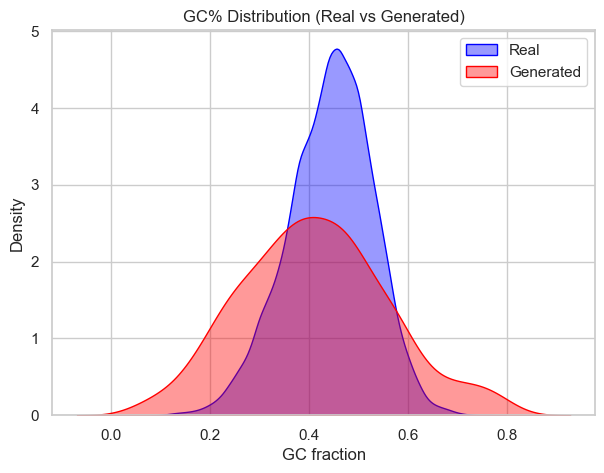

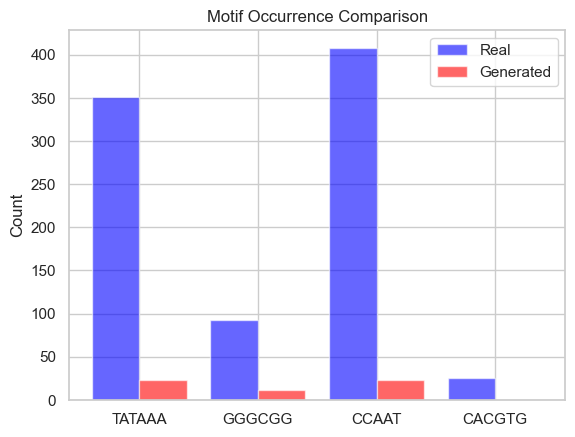

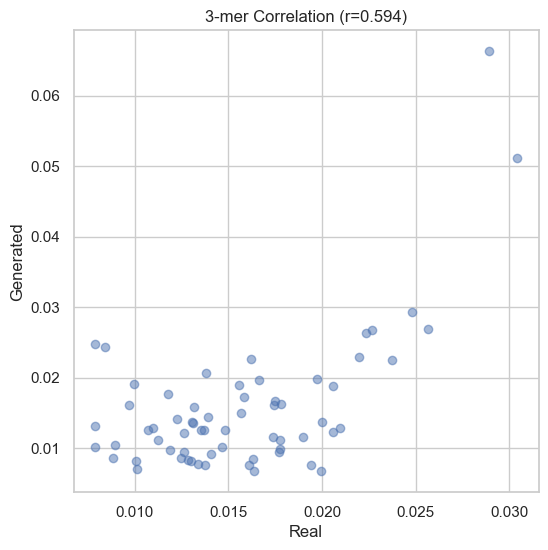

<Figure size 1200x300 with 0 Axes>

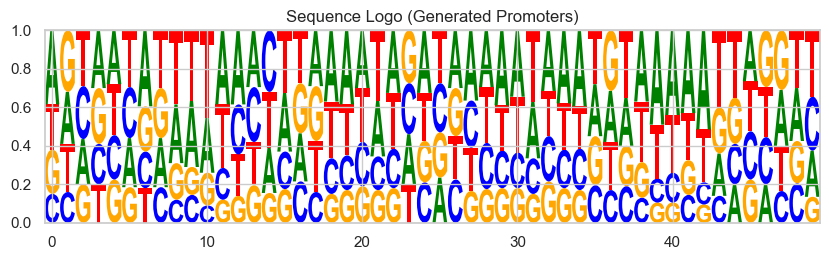

GC mean (real)=0.443, (gen)=0.412
3-mer correlation = 0.594


In [79]:
# ---------- helpers ----------
def gc_content(seq): return (seq.count("G")+seq.count("C"))/len(seq)
def kmer_freqs(seqs, k=3):
    all_kmers = [''.join(p) for p in product('ACGT', repeat=k)]
    counts = Counter()
    for seq in seqs:
        for i in range(len(seq)-k+1):
            counts[seq[i:i+k]] += 1
    total = sum(counts.values())
    return np.array([counts[km]/total for km in all_kmers]), all_kmers
def onehot_to_df(seqs):
    L = len(seqs[0])
    df = pd.DataFrame(0, index=list("ACGT"), columns=range(L))
    for seq in seqs:
        for i,b in enumerate(seq):
            if b in "ACGT":
                df.loc[b,i]+=1
    return (df/df.sum()).T

# ---------- GC content ----------
gc_real = [gc_content(s) for s in real_sequences]
gc_gen = [gc_content(s) for s in gen_sequences]
plt.figure(figsize=(7,5))
sns.kdeplot(gc_real, fill=True, color='blue', label='Real', alpha=0.4)
sns.kdeplot(gc_gen, fill=True, color='red', label='Generated', alpha=0.4)
plt.title("GC% Distribution (Real vs Generated)")
plt.xlabel("GC fraction"); plt.legend(); plt.show()

# ---------- Motif counts ----------
motifs = ["TATAAA", "GGGCGG", "CCAAT", "CACGTG"]
motif_counts_real = [sum(m in s for s in real_sequences) for m in motifs]
motif_counts_gen = [sum(m in s for s in gen_sequences) for m in motifs]
x = np.arange(len(motifs))
plt.bar(x-0.2, motif_counts_real, 0.4, label='Real', color='blue', alpha=0.6)
plt.bar(x+0.2, motif_counts_gen, 0.4, label='Generated', color='red', alpha=0.6)
plt.xticks(x, motifs); plt.ylabel("Count"); plt.legend()
plt.title("Motif Occurrence Comparison"); plt.show()

# ---------- 3-mer correlation ----------
real_k, _ = kmer_freqs(real_sequences)
gen_k, _ = kmer_freqs(gen_sequences)
corr = np.corrcoef(real_k, gen_k)[0,1]
plt.figure(figsize=(6,6))
plt.scatter(real_k, gen_k, alpha=0.5)
plt.title(f"3-mer Correlation (r={corr:.3f})")
plt.xlabel("Real"); plt.ylabel("Generated"); plt.show()

# ---------- Sequence logo ----------
df_gen = onehot_to_df(gen_sequences[:200])
plt.figure(figsize=(12,3))
logomaker.Logo(df_gen)
plt.title("Sequence Logo (Generated Promoters)"); plt.show()

print(f"GC mean (real)={np.mean(gc_real):.3f}, (gen)={np.mean(gc_gen):.3f}")
print(f"3-mer correlation = {corr:.3f}")

Deeper model with residual connections

In [80]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# -----------------------------
# Basic Residual Block (1D)
# -----------------------------
class ResBlock(nn.Module):
    def __init__(self, in_ch, out_ch, kernel_size=5, dropout=0.1, seq_len=57):
        super().__init__()
        self.conv1 = nn.Conv1d(in_ch, out_ch, kernel_size, padding=kernel_size//2)
        self.conv2 = nn.Conv1d(out_ch, out_ch, kernel_size, padding=kernel_size//2)
        self.ln1 = nn.LayerNorm([out_ch, seq_len])
        self.ln2 = nn.LayerNorm([out_ch, seq_len])
        self.dropout = nn.Dropout(dropout)
        self.shortcut = (
            nn.Conv1d(in_ch, out_ch, 1) if in_ch != out_ch else nn.Identity()
        )

    def forward(self, x):
        residual = self.shortcut(x)
        out = F.relu(self.ln1(self.conv1(x)))
        out = self.dropout(F.relu(self.ln2(self.conv2(out))))
        return out + residual  # skip connection
        

# -----------------------------
# Residual Deep Convolutional VAE
# -----------------------------
class ResidualDeepConvVAE(nn.Module):
    def __init__(self, L=57, z_dim=256, base_c=64, dropout=0.1):
        super().__init__()
        self.L = L
        self.base_c = base_c

        # ----- Encoder -----
        self.enc_blocks = nn.Sequential(
            ResBlock(4, base_c, dropout=dropout, seq_len=L),
            ResBlock(base_c, base_c, dropout=dropout, seq_len=L),
            ResBlock(base_c, base_c*2, dropout=dropout, seq_len=L),
            ResBlock(base_c*2, base_c*2, dropout=dropout, seq_len=L),
            ResBlock(base_c*2, base_c*4, dropout=dropout, seq_len=L),
            ResBlock(base_c*4, base_c*4, dropout=dropout, seq_len=L),
        )

        enc_out_dim = base_c*4*L
        self.fc_mu = nn.Linear(enc_out_dim, z_dim)
        self.fc_logvar = nn.Linear(enc_out_dim, z_dim)

        # ----- Decoder -----
        self.fc_dec = nn.Linear(z_dim, enc_out_dim)
        self.dec_blocks = nn.Sequential(
            ResBlock(base_c*4, base_c*4, dropout=dropout, seq_len=L),
            ResBlock(base_c*4, base_c*2, dropout=dropout, seq_len=L),
            ResBlock(base_c*2, base_c*2, dropout=dropout, seq_len=L),
            ResBlock(base_c*2, base_c, dropout=dropout, seq_len=L),
            ResBlock(base_c, base_c, dropout=dropout, seq_len=L),
            nn.Conv1d(base_c, 4, 1)  # output logits
        )

    def encode(self, x):
        x = x.permute(0, 2, 1)  # (B,4,L)
        h = self.enc_blocks(x)
        h = h.flatten(start_dim=1)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparam(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = self.fc_dec(z)
        h = h.view(-1, self.base_c*4, self.L)
        out = self.dec_blocks(h)
        return out.permute(0, 2, 1)  # (B,L,4)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparam(mu, logvar)
        logits = self.decode(z)
        return logits, mu, logvar

In [92]:
def vae_loss(logits, target, mu, logvar, beta=0.05):
    recon = F.cross_entropy(logits.reshape(-1,4), target.argmax(-1).reshape(-1))
    kl = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    return recon + beta * kl, recon, kl

model = ResidualDeepConvVAE(L=L, z_dim=256, base_c=64, dropout=0.1).to(DEVICE)
opt = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=1e-4)
EPOCHS = 200
best_val = 1e9

for epoch in range(1, EPOCHS+1):
    model.train(); tr_loss = 0
    for xb in train_dl:
        xb = xb.to(DEVICE)
        logits, mu, logvar = model(xb)
        loss, rec, kl = vae_loss(logits, xb, mu, logvar, beta=0.05)
        opt.zero_grad()
        loss.backward()
        opt.step()
        tr_loss += loss.item() * xb.size(0)
    tr_loss /= len(train_dl.dataset)

    model.eval(); val_loss = 0
    with torch.no_grad():
        for xb in val_dl:
            xb = xb.to(DEVICE)
            logits, mu, logvar = model(xb)
            loss, _, _ = vae_loss(logits, xb, mu, logvar, beta=0.05)
            val_loss += loss.item() * xb.size(0)
    val_loss /= len(val_dl.dataset)
    print(f"Epoch {epoch:03d} | train={tr_loss:.4f} | val={val_loss:.4f}")

    if val_loss < best_val:
        best_val = val_loss
        torch.save(model.state_dict(), "models/vae_promoter_residual.pt")
        print(f"✅ Saved best model (val={best_val:.4f})")

Epoch 001 | train=0.8083 | val=0.0840
✅ Saved best model (val=0.0840)
Epoch 002 | train=0.0876 | val=0.0705
✅ Saved best model (val=0.0705)
Epoch 003 | train=0.0751 | val=0.0668
✅ Saved best model (val=0.0668)
Epoch 004 | train=0.0691 | val=0.0623
✅ Saved best model (val=0.0623)
Epoch 005 | train=0.0655 | val=0.0607
✅ Saved best model (val=0.0607)
Epoch 006 | train=0.0634 | val=0.0600
✅ Saved best model (val=0.0600)
Epoch 007 | train=0.0619 | val=0.0569
✅ Saved best model (val=0.0569)
Epoch 008 | train=0.0603 | val=0.0561
✅ Saved best model (val=0.0561)
Epoch 009 | train=0.0598 | val=0.0555
✅ Saved best model (val=0.0555)
Epoch 010 | train=0.0584 | val=0.0553
✅ Saved best model (val=0.0553)
Epoch 011 | train=0.0576 | val=0.0541
✅ Saved best model (val=0.0541)
Epoch 012 | train=0.0566 | val=0.0531
✅ Saved best model (val=0.0531)
Epoch 013 | train=0.0560 | val=0.0531
Epoch 014 | train=0.0552 | val=0.0529
✅ Saved best model (val=0.0529)
Epoch 015 | train=0.0539 | val=0.0508
✅ Saved best m

In [93]:
model.load_state_dict(torch.load("models/vae_promoter_residual.pt", map_location=DEVICE))
model.eval()

N = 500
z = torch.randn(N, 256).to(DEVICE) * 1.5  # larger variance for diversity
with torch.no_grad():
    logits = model.decode(z)
    probs = torch.softmax(logits, dim=-1)
    sampled = torch.argmax(probs, dim=-1).cpu().numpy()

idx2nt = np.array(["A","C","G","T"])
gen_sequences = ["".join(idx2nt[s]) for s in sampled]
print(f"Generated {len(gen_sequences)} new promoter sequences.")
print(gen_sequences[0][:80])

Generated 500 new promoter sequences.
GGCGTTAGGGCAGAGTCCGCCGACTTGGGAATTTGACTCCAGGTTCCTAC


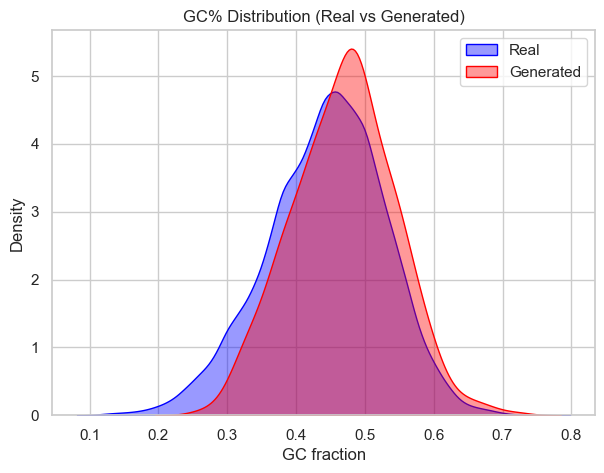

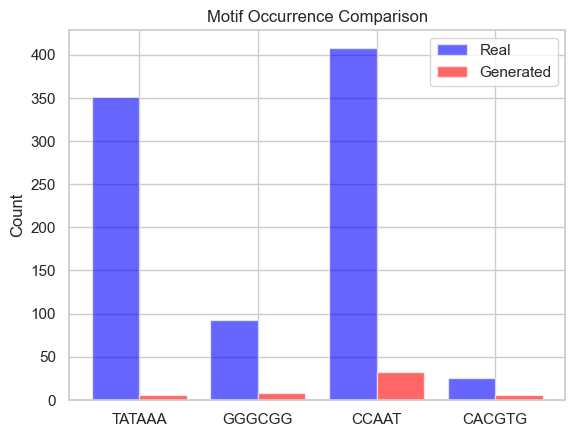

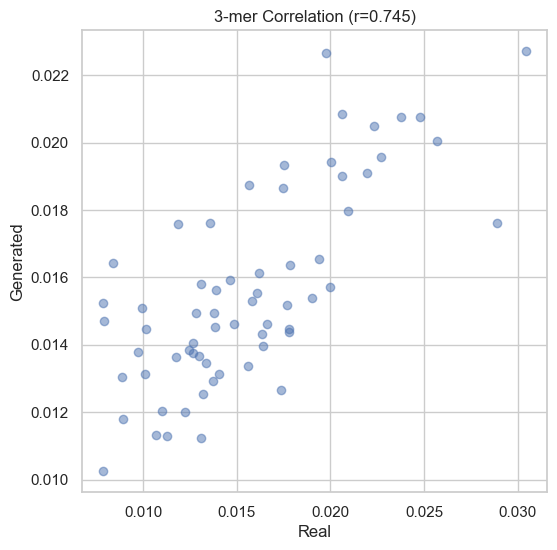

<Figure size 1200x300 with 0 Axes>

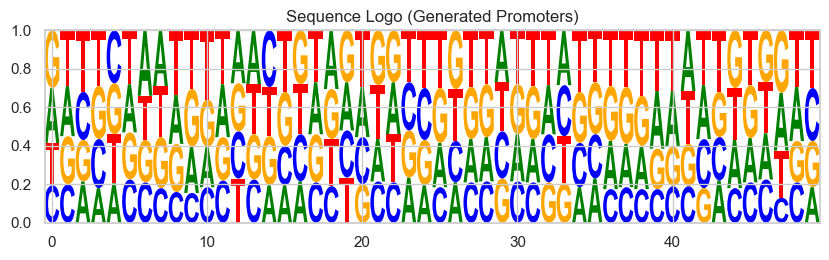

GC mean (real)=0.443, (gen)=0.469
3-mer correlation = 0.745


In [94]:
# ---------- helpers ----------
def gc_content(seq): return (seq.count("G")+seq.count("C"))/len(seq)
def kmer_freqs(seqs, k=3):
    all_kmers = [''.join(p) for p in product('ACGT', repeat=k)]
    counts = Counter()
    for seq in seqs:
        for i in range(len(seq)-k+1):
            counts[seq[i:i+k]] += 1
    total = sum(counts.values())
    return np.array([counts[km]/total for km in all_kmers]), all_kmers
def onehot_to_df(seqs):
    L = len(seqs[0])
    df = pd.DataFrame(0, index=list("ACGT"), columns=range(L))
    for seq in seqs:
        for i,b in enumerate(seq):
            if b in "ACGT":
                df.loc[b,i]+=1
    return (df/df.sum()).T

# ---------- GC content ----------
gc_real = [gc_content(s) for s in real_sequences]
gc_gen = [gc_content(s) for s in gen_sequences]
plt.figure(figsize=(7,5))
sns.kdeplot(gc_real, fill=True, color='blue', label='Real', alpha=0.4)
sns.kdeplot(gc_gen, fill=True, color='red', label='Generated', alpha=0.4)
plt.title("GC% Distribution (Real vs Generated)")
plt.xlabel("GC fraction"); plt.legend(); plt.show()

# ---------- Motif counts ----------
motifs = ["TATAAA", "GGGCGG", "CCAAT", "CACGTG"]
motif_counts_real = [sum(m in s for s in real_sequences) for m in motifs]
motif_counts_gen = [sum(m in s for s in gen_sequences) for m in motifs]
x = np.arange(len(motifs))
plt.bar(x-0.2, motif_counts_real, 0.4, label='Real', color='blue', alpha=0.6)
plt.bar(x+0.2, motif_counts_gen, 0.4, label='Generated', color='red', alpha=0.6)
plt.xticks(x, motifs); plt.ylabel("Count"); plt.legend()
plt.title("Motif Occurrence Comparison"); plt.show()

# ---------- 3-mer correlation ----------
real_k, _ = kmer_freqs(real_sequences)
gen_k, _ = kmer_freqs(gen_sequences)
corr = np.corrcoef(real_k, gen_k)[0,1]
plt.figure(figsize=(6,6))
plt.scatter(real_k, gen_k, alpha=0.5)
plt.title(f"3-mer Correlation (r={corr:.3f})")
plt.xlabel("Real"); plt.ylabel("Generated"); plt.show()

# ---------- Sequence logo ----------
df_gen = onehot_to_df(gen_sequences[:200])
plt.figure(figsize=(12,3))
logomaker.Logo(df_gen)
plt.title("Sequence Logo (Generated Promoters)"); plt.show()

print(f"GC mean (real)={np.mean(gc_real):.3f}, (gen)={np.mean(gc_gen):.3f}")
print(f"3-mer correlation = {corr:.3f}")